In [238]:
class Config():
  def __init__(
    self,
    num_classes,
    num_epochs,
    batch_size,
    early_stopping_patience,
    early_stopping_min_delta,
    use_saved_models,
    train_size,
    test_size,
    val_size,
    checkpoint_path,
  ):
    self.num_classes = num_classes
    self.num_epochs = num_epochs
    self.batch_size = batch_size
    self.early_stopping_patience = early_stopping_patience
    self.early_stopping_min_delta = early_stopping_min_delta

    self.use_saved_models = use_saved_models
    
    self.train_size = train_size
    self.test_size = test_size
    self.val_size = val_size

    self.checkpoint_path = checkpoint_path

cfg = Config(
    num_classes=4,
    num_epochs=100, # Due to dropout
    batch_size = 16,
    early_stopping_patience = 20, # Due to dropout
    early_stopping_min_delta = 0.01,
    use_saved_models = False,
    train_size = 0.9,
    test_size = 0.05,
    val_size = 0.05,
    checkpoint_path = '1-best-tabular-model.keras',
)

# Обработка данных

## Очистка

In [224]:
import pandas as pd
import numpy as np
from ast import literal_eval
from dateutil.parser import parse

df = pd.read_csv('./movie_dataset.csv', index_col=0)

to_drop = [
    'id', 
    'tagline', 
    'overview', 
    'vote_average', 
    'vote_count', 
    'domestic_opening', 
    'original_title', 
    'title', 
    'spoken_languages',
    'poster',
    'original_language',
]
df = df.drop(columns=to_drop)

df['budget'] = df['budget'].replace({0: np.NAN})
df['revenue'] = df['revenue'].replace({0: np.NAN})
df['runtime'] = df['runtime'].replace({0: np.NAN})

df.dropna(inplace=True)
df = df[df['status'] == 'Released']
df = df.drop(columns=['status'], axis=1)

literal_eval_cols = ['genres', 'production_countries', 'production_companies', 'actors']

for col in literal_eval_cols:
    df[col] = df.apply(lambda x: literal_eval(x[col]), axis=1)

df['production_company'] = df.apply(lambda x: x['production_companies'][0], axis=1)
df['production_country'] = df.apply(lambda x: x['production_countries'][0], axis=1)
df = df.drop(columns=['production_companies', 'production_countries'], axis=1)

to_delete = ['M/PG', 'GP', 'Approved', 'M', 'Not Rated']
df = df[~df['mpaa'].isin(to_delete)]

df = df[df['actors'].map(len) == 3]
df = df.join(pd.DataFrame(df['actors'].values.tolist(), df.index, ['actor_1', 'actor_2', 'actor_3']))
df = df.drop(['actors'], axis=1)

m = df.apply(lambda x: parse(x['release_date']).month, axis=1)
df = df.join(m.rename('release_month'))
df = df.drop(columns=['release_date'], axis=1)

df = df.drop(columns=['imdb_id'], axis=1)

df = df.reset_index(drop=True)

## Формирование целевой переменной

In [225]:
def get_class(row):
  R = row['revenue']
  B = row['budget']
  if R < B:
    return 0
  elif B <= R < 2*B:
    return 1
  elif 2*B <= R < 4*B:
    return 2
  elif 4*B <= R:
    return 3
  return np.NAN

df['target'] = df.apply(get_class, axis=1)
df = df.drop(columns=['revenue'], axis=1)

## Извлечение и преобразование признаков

In [226]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import MultiLabelBinarizer, StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline

class PreprocessingTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        return

    def fit(self, X, y=None):
        # Жанры
        self.genres_mlb = MultiLabelBinarizer().fit(X['genres'].values)
        # Продюсерская компания
        self.production_company_encoder = LabelEncoder().fit(X['production_company'].values)
        # Страна производства
        self.production_country_encoder = LabelEncoder().fit(X['production_country'].values)
        # Дистрибьютор
        self.domestic_distributor_encoder = LabelEncoder().fit(X['domestic_distributor'].values)
        # Режиссер
        self.director_encoder = LabelEncoder().fit(X['director'].values)
        # Актеры
        unique_actors = pd.concat([df['actor_1'], df['actor_2'], df['actor_3']]).unique()
        self.actor_encoder = LabelEncoder().fit(unique_actors)
        # Месяц выхода
        self.release_month_encoder = OneHotEncoder(sparse_output=False).fit(X['release_month'].values.reshape(-1, 1))
        # Возрастной рейтинг
        self.mpaa_encoder = OneHotEncoder(sparse_output=False).fit(X['mpaa'].values.reshape(-1, 1))
        # Бюджет
        self.budget_scaler = StandardScaler().fit(X['budget'].values.reshape(-1, 1))
        # Длительность
        self.runtime_scaler = StandardScaler().fit(X['runtime'].values.reshape(-1, 1))

        self.columns_order = [
            'actor_1', 'actor_2', 'actor_3', 'director', 'production_company', 'production_country', 'domestic_distributor', 
            'runtime', 'budget', 
            'genre_action', 'genre_adventure', 'genre_animation',
            'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama',
            'genre_family', 'genre_fantasy', 'genre_foreign', 'genre_history',
            'genre_horror', 'genre_music', 'genre_mystery', 'genre_romance',
            'genre_science_fiction', 'genre_thriller', 'genre_war', 'genre_western',
            'release_month_1', 'release_month_2', 'release_month_3',
            'release_month_4', 'release_month_5', 'release_month_6',
            'release_month_7', 'release_month_8', 'release_month_9',
            'release_month_10', 'release_month_11', 'release_month_12', 
            'mpaa_G', 'mpaa_NC-17', 'mpaa_PG', 'mpaa_PG-13', 'mpaa_R'
        ]

        return self

    def transform(self, X):
        # Жанры
        classes = [f'genre_{x.replace(" ", "_").lower()}' for x in self.genres_mlb.classes_]
        transformed_genres = self.genres_mlb.transform(X['genres'].values)
        X = X.join(pd.DataFrame(transformed_genres.astype(bool), X.index, classes))
        X = X.drop(columns=['genres'], axis=1)
        # Продюсерская компания
        X['production_company'] = self.production_company_encoder.transform(X['production_company'].values)
        # Страна производства
        X['production_country'] = self.production_country_encoder.transform(X['production_country'].values)
        # Дистрибьютор
        X['domestic_distributor'] = self.domestic_distributor_encoder.transform(X['domestic_distributor'].values)
        # Режиссер
        X['director'] = self.director_encoder.transform(X['director'].values)
        # Актеры
        for i in range(1, 4):
            X[f'actor_{i}'] = self.actor_encoder.transform(X[f'actor_{i}'].values)
        # Месяц выхода
        classes = [f'release_month_{x}' for x in self.release_month_encoder.categories_[0]]
        transfored_release_month = self.release_month_encoder.transform(X['release_month'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_release_month.astype(bool), X.index, classes))
        X = X.drop(columns=['release_month'], axis=1)
        # Возрастной рейтинг
        classes = [('mpaa_' + x.upper()) for x in self.mpaa_encoder.categories_[0]]
        transfored_mpaa = self.mpaa_encoder.transform(X['mpaa'].values.reshape(-1, 1))
        X = X.join(pd.DataFrame(transfored_mpaa.astype(bool), X.index, classes))
        X = X.drop(columns=['mpaa'], axis=1)
        # Бюджет
        X['budget'] = self.budget_scaler.transform(X['budget'].values.reshape(-1, 1))
        # Длительность
        X['runtime'] = self.runtime_scaler.transform(X['runtime'].values.reshape(-1, 1))

        X = X[self.columns_order]

        return X

preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', PreprocessingTransformer()),
]) 

X = df.drop(columns=['target'], axis=1)
y = df['target'].to_numpy()

# Fit and evaluate the model
X = preprocess_pipeline.fit_transform(X, y)

### Сохранение преобразования признаков

In [227]:
import dill

with open('./pipeline.pkl', 'wb') as f:
    dill.dump(preprocess_pipeline, f, protocol=5)

# Построение и обучение модели

Опишем фукнцию, которая будет оценивать получившуюся модель

In [228]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

results = {}

# Функция для оценки полученной модели
def inspect_model(model, X, y, model_name, history=None):
  predictions = model.predict(X)
  # real_classes = y.argmax(axis=1)
  real_classes = y
  predicted_classes = predictions.argmax(axis=1)

  # Exact and 1-class-away accuracy
  diffs = abs(real_classes - predicted_classes)

  exact_match = len(diffs[diffs <= 0]) / len(diffs)
  one_class_away = len(diffs[diffs <= 1]) / len(diffs)
  print('Exact match accuracy:', exact_match)
  print('One class away accuracy:', one_class_away)

  # Precision and recall
  precision = precision_score(real_classes, predicted_classes, average=None)
  recall = recall_score(real_classes, predicted_classes, average=None)
  f1 = f1_score(real_classes, predicted_classes, average=None)
  print("Precision per class:", precision)
  print("Recall per class:", recall)
  print("F1 score per class", f1)

  # Macro and Micro averaged Precision and Recall
  macro_precision = precision_score(real_classes, predicted_classes, average='macro')
  macro_recall = recall_score(real_classes, predicted_classes, average='macro')
  micro_precision = precision_score(real_classes, predicted_classes, average='micro')
  micro_recall = recall_score(real_classes, predicted_classes, average='micro')
  macro_f1 = f1_score(real_classes, predicted_classes, average='macro')
  micro_f1 = f1_score(real_classes, predicted_classes, average='micro')

  print("Macro Precision:", macro_precision)
  print("Macro Recall:", macro_recall)
  print("Macro F1:", macro_f1)
  print("Micro Precision:", micro_precision)
  print("Micro Recall:", micro_recall)
  print("Micro F1:", micro_f1)
  
  # Confusion matrix
  m = confusion_matrix(real_classes, predicted_classes)
  ConfusionMatrixDisplay(m).plot()

  if (history != None):
    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss Function Over Epochs')
    ax.set_ylabel('Sparse Categorical Crossentropy value')
    ax.set_xlabel('No. epoch')
    plt.show()

    fig = plt.figure()
    ax = fig.add_subplot()
    ax.plot(history.history['val_accuracy'])
    ax.set_title('Accuracy Over Epochs')
    ax.set_ylabel('Accuracy value')
    ax.set_xlabel('No. epoch')
    plt.show()

  results[model_name] = {
      'exact_match': exact_match,
      'one_class_away': one_class_away,
  }

## Архитектура модели

In [229]:
import tensorflow as tf
import keras

@keras.saving.register_keras_serializable()
class SliceLayer(tf.keras.layers.Layer):
    def __init__(self, start_index, **kwargs):
        super(SliceLayer, self).__init__(**kwargs)
        self.start_index = start_index

    def call(self, inputs):
        # Your custom slicing logic goes here
        return inputs[:, self.start_index:]

    def get_config(self):
        config = super(SliceLayer, self).get_config()
        config.update({
            "start_index": self.start_index,
        })
        return config
    
@keras.saving.register_keras_serializable()
class IndexAndExpandLayer(tf.keras.layers.Layer):
    def __init__(self, index, **kwargs):
        super(IndexAndExpandLayer, self).__init__(**kwargs)
        self.index = index

    def call(self, inputs):
        # Your custom slicing logic goes here
        return tf.expand_dims(inputs[:,self.index],-1)

    def get_config(self):
        config = super(IndexAndExpandLayer, self).get_config()
        config.update({
            "index": self.index,
        })
        return config

In [251]:
import keras
from keras import layers
from keras.models import Model
import tensorflow as tf

def build_model(
    original_input_shape,
    n_unique_actors,
    n_unique_directors,
    n_unique_production_companies,
    n_unique_production_countries, 
    n_unique_domestic_distributor,
    n_classes,
):
    def out_dim(n):
        # return math.ceil(math.pow(n, 0.25))
        return 20
    
    def build_embedding_cfg(
        name, input_dim, output_dim=out_dim(None), 
    ):
        return {
            'name': name,
            'input_dim': input_dim,
            'output_dim': output_dim,
        }
    
    keras.config.enable_unsafe_deserialization()
    
    input = layers.Input(shape=(original_input_shape,))
    
    embedding_cfg = [
        build_embedding_cfg('actor_1', n_unique_actors),
        build_embedding_cfg('actor_2', n_unique_actors),
        build_embedding_cfg('actor_3', n_unique_actors),
        build_embedding_cfg('director', n_unique_directors),
        build_embedding_cfg('production_company', n_unique_production_companies),
        build_embedding_cfg('production_country', n_unique_production_countries),
        build_embedding_cfg('domestic_distributor', n_unique_domestic_distributor),
    ]

    embedding_outputs = []
    for i, cfg in enumerate(embedding_cfg):
        # embedded_lambda = layers.Lambda(lambda x: tf.expand_dims(x[:,i],-1))(input)
        embedded_lambda = IndexAndExpandLayer(i)(input)
        embedding = layers.Embedding(
            input_dim=cfg['input_dim'],
            output_dim=cfg['output_dim'],
            name=cfg['name'],
        )(embedded_lambda)
        output = layers.Flatten()(embedding)

        embedding_outputs.append(output)

    # other_lambda = layers.Lambda(lambda x: x[:,len(embedding_cfg):])(input)
    other_lambda = SliceLayer(len(embedding_cfg))(input)

    merged = layers.concatenate([
        *embedding_outputs,
        other_lambda
    ])

    hidden = layers.Dense(128, activation='relu')(merged)
    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(96, activation='relu')(hidden)
    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(64, activation='relu')(hidden)
    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(32, activation='relu')(hidden)
    hidden = layers.Dropout(0.4)(hidden)
    hidden = layers.Dense(16, activation='relu')(hidden)
    output = layers.Dense(n_classes, activation='softmax')(hidden)

    inputs = input
    model = Model(inputs=inputs, outputs=output)

    return model

In [231]:
from keras.utils import plot_model

m = build_model(
    original_input_shape=X.shape[1],
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
)
plot_model(m, show_shapes=True, show_layer_activations=True, show_layer_names=True)

## Поиск оптимальных парметров обучения с помощью HalvingGridSearchCV

Разбиваем исходный датасет следующим образом: 90% - тренировочный, 5% - валидационный, 5% - тестовый.

In [232]:
from sklearn.model_selection import train_test_split

X_train, X_dum, y_train, y_dum = train_test_split(X, y, test_size=1-cfg.train_size, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_dum, y_dum, test_size=cfg.test_size/(cfg.test_size + cfg.val_size), stratify=y_dum)

print('Train size:', cfg.train_size)
print('Test size:', (1-cfg.train_size) * cfg.test_size/(cfg.test_size + cfg.val_size))
print('Val size:', (1-cfg.train_size) * cfg.val_size/(cfg.test_size + cfg.val_size))

print('Train size:', X_train.shape)
print('Test size:', X_test.shape)
print('Val size:', X_val.shape)

Train size: 0.9
Test size: 0.04999999999999999
Val size: 0.04999999999999999
Train size: (3790, 45)
Test size: (211, 45)
Val size: (211, 45)


Разделяем исходный датасет на категориальные и остальные признаки

In [233]:
def separate_categorical_attributes(X):
    columns = [
        'actor_1', 'actor_2', 'actor_3', 
        'director', 
        'production_company', 
        'production_country', 
        'domestic_distributor',
    ]
    result = [X[c].values.astype(float) for c in columns]
    result.append(X.drop(columns=columns, axis=1).values.astype(float))
    return result

Определяем веса классов для сбаланированного разбиения (относительного целевого класса) на тренировочные и тестовые данные

In [234]:
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)
class_weights = {i: x for i, x in enumerate(class_weights)}

In [235]:
from keras.callbacks import EarlyStopping
from sklearn.experimental import enable_halving_search_cv
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import HalvingGridSearchCV

def find_optimal_hyperparameters():
    def create_model():
        return build_model(
            original_input_shape=X.shape[1],
            n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
            n_unique_directors=X['director'].nunique(),
            n_unique_production_companies=X['production_company'].nunique(),
            n_unique_production_countries=X['production_country'].nunique(),
            n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
            n_classes=cfg.num_classes,
        )

    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience)

    model = KerasClassifier(
        build_fn=create_model,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy'],
        epochs=cfg.num_epochs,
        class_weight=class_weights,
        callbacks=[
            early_stopping,
        ],
        validation_split=0.1,
    )

    params = {
        'optimizer': ['adam', 'adamw', 'adadelta', 'adagrad'],
        'batch_size': [16, 32, 64],
        "optimizer__learning_rate": [0.001, 0.01, 0.1]
    }
    grid = HalvingGridSearchCV(
        estimator=model, 
        param_grid=params,
        scoring='accuracy',
        factor=3,
        cv=5,
        n_jobs=10,
    )

    grid_result = grid.fit(X_train, y_train)

    return grid_result
    

In [236]:
grid_result = find_optimal_hyperparameters()
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

2025-04-23 02:55:31.467966: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 02:55:31.472327: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-23 02:55:31.485325: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-23 02:55:31.508952: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
E0000 00:00:1745366131.510676  370197 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-23 02:55:31.514201: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
E0000 00:00:1745366131.

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2025-04-23 02:55:35.464889: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
2025-04-23 02:55:35.721464: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 108ms/step - accuracy: 0.2348 - loss: 1.3685 - val_accuracy: 0.1667 - val_loss: 1.3250
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - accuracy: 0.2149 - loss: 1.3953 - val_accuracy: 0.2500 - val_loss: 1.3810
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1876 - loss: 1.3933 - val_accuracy: 0.1667 - val_loss: 1.3785
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 136ms/step - accuracy: 0.2093 - loss: 1.4432 - val_accuracy: 0.2500 - val_loss: 1.4003
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2574 - loss: 1.4383 - val_accuracy: 0.2500 - val_loss: 1.3711
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 134ms/step - accuracy: 0.3860 - loss: 1.3306 - val_accuracy: 0.0833 - val_loss: 1.3607
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 120ms/step - accuracy: 0.2412 - loss: 1.4612 - val_accuracy: 0.1667 - val_loss: 1.3697
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.1375 - loss: 1.4214 - val_accuracy: 0.0833 - val_

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2329 - loss: 1.3876 - val_accuracy: 0.4167 - val_loss: 1.3406
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7426 - loss: 0.6731 - val_accuracy: 0.0833 - val_loss: 1.8364
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6983 - loss: 0.6585 - val_accuracy: 0.4167 - val_loss: 2.1171
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 433ms/stepEpoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2595 - loss: 1.3829 - val_accuracy: 0.3333 - val_loss: 1.3567
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7195 - loss: 0.4832 - val_accuracy: 0.0833 - val_loss: 2.1648
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.8772 - loss: 0.3319 - val_accuracy: 0.0833 - val_loss: 1.6528
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6761 - loss: 0.7404 - val_accuracy: 0.1667 - val_loss: 1.9798
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.4375 - loss: 0.9020Epoch 1/100
7/

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.8790 - loss: 0.4021 - val_accuracy: 0.3333 - val_loss: 1.5900
Epoch 30/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 405ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3896 - loss: 1.3209 - val_accuracy: 0.5000 - val_loss: 1.3322
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2959 - loss: 1.3189 - val_accuracy: 0.2500 - val_loss: 1.3496
Epoch 27/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8159 - loss: 0.4480 - val_accuracy: 0.2500 - val_loss: 2.1398
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8214 - loss: 0.4471 - val_accuracy: 0.1667 - val_loss: 2.0706
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch 31/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.8125 - loss: 0.4512Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3117 - loss: 1.3690 - val_accuracy: 0.1667 - val_loss: 1.3460
Epoch 28/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2951 - loss: 1.3052 - val_a

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2470 - loss: 1.3148 - val_accuracy: 0.2500 - val_loss: 1.3342
Epoch 31/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4283 - loss: 1.3853 - val_accuracy: 0.1667 - val_loss: 1.3394
Epoch 36/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 337ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2977 - loss: 1.2788 - val_accuracy: 0.2500 - val_loss: 1.3336
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3521 - loss: 1.3227 - val_accuracy: 0.1667 - val_loss: 1.3410
Epoch 37/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2150 - loss: 1.3436 - val_accuracy: 0.2500 - val_loss: 1.3314
Epoch 33/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 341ms/step- accuracy: 0.5625 - loss: 1.15
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4840 - loss: 1.3100 - val_accuracy: 0.2500 - val_loss: 1.3375
Epoch 38/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  - accuracy: 0.3125 - loss: 1.17
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 314ms/step
7/7 ━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3814 - loss: 1.3093 - val_accuracy: 0.4167 - val_loss: 1.3282
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2954 - loss: 1.2989 - val_accuracy: 0.2500 - val_loss: 1.3184
Epoch 41/100
Epoch 36/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3750 - loss: 1.3443

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2500 - loss: 1.3043 - val_accuracy: 0.2500 - val_loss: 1.3201
Epoch 37/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3952 - loss: 1.2683 - val_accuracy: 0.4167 - val_loss: 1.3221
Epoch 42/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3125 - loss: 1.2371Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3542 - loss: 1.2375 - val_accuracy: 0.3333 - val_loss: 1.3161
Epoch 43/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3750 - loss: 1.2545 - val_accuracy: 0.2500 - val_loss: 1.3191
Epoch 38/100
Epoch 1/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3193 - loss: 1.2664 - val_accuracy: 0.2500 - val_loss: 1.3180
Epoch 39/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3921 - loss: 1.2145 - val_accuracy: 0.2500 - val_loss: 1.3091
Epoch 44/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3313 - loss: 1.1925 - val_accuracy: 0.2500 - val_loss: 1.3044
Epoch

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.7450 - loss: 0.5847 - val_accuracy: 0.3333 - val_loss: 1.3788
Epoch 74/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1783 - loss: 2.8537 - val_accuracy: 0.1667 - val_loss: 1.3007
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2487 - loss: 3.6059 - val_accuracy: 0.2500 - val_loss: 1.3107
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3010 - loss: 1.3744 - val_accuracy: 0.3333 - val_loss: 1.3048
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2685 - loss: 1.6569 - val_accuracy: 0.2500 - val_loss: 1.3691
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2214 - loss: 1.3767 - val_accuracy: 0.4167 - val_loss: 1.3531
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2305 - loss: 1.3796 - val_accuracy: 0.1667 - val_loss: 1.3733
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.4375 - loss: 1.2332Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2454 - loss: 1.3596 - val_accuracy: 0.1667 - val_loss: 1.3027
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2189 - loss: 3.4634 - val_accuracy: 0.4167 - val_loss: 1.3878
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3750 - loss: 1.3454Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3589 - loss: 1.3484 - val_accuracy: 0.3333 - val_loss: 1.3714
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1976 - loss: 1.4018 - val_accuracy: 0.2500 - val_loss: 1.3760
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2996 - loss: 1.3088 - val_accuracy: 0.3333 - val_loss: 1.2924
Epoch 18/100
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2326 - loss: 282.0630 - val_accuracy: 0.3333 - val_loss: 1.3835
Epoch 29/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4375 - loss: 1.2766Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2412 - loss: 1.3668 - val_accu

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2792 - loss: 1.7215 - val_accuracy: 0.3333 - val_loss: 1.3820
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2040 - loss: 1.4006 - val_accuracy: 0.0833 - val_loss: 1.3759
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step p - accuracy: 0.5000 - loss: 1.390
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2790 - loss: 1.3505 - val_accuracy: 0.0833 - val_loss: 1.4343
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3049 - loss: 1.3701 - val_accuracy: 0.5000 - val_loss: 1.2796
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3767 - loss: 1.3318 - val_accuracy: 0.1667 - val_loss: 1.3787
Epoch 22/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3633 - loss: 1.3567 - val_accuracy: 0.5000 - val_loss: 1.2945
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2118 - loss: 1.3733 - val_accuracy: 0.1667 - val_loss: 1.3747
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3266 - loss: 1.3478 - val_accuracy: 0.1667 - val_loss: 1.2933
Epoch 38/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3460 - loss: 1.3312 - val_accuracy: 0.2500 - val_loss: 1.4141
Epoch 28/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 338ms/step - accuracy: 0.0000e+00 - loss: 1.26
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4272 - loss: 1.2395 - val_accuracy: 0.3333 - val_loss: 1.4195
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2228 - loss: 1.3085 - val_accuracy: 0.4167 - val_loss: 1.2949
Epoch 26/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.1589 - loss: 1.3361 - val_accuracy: 0.5000 - val_loss: 1.2846
Epoch 39/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 368ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  - accuracy: 0.3125 - loss: 1.4731
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3457 - loss: 1.2862 - val_accuracy: 0.4167 - val_loss: 1.2929
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2871 - loss: 1

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3125 - loss: 1.3855Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3258 - loss: 1.3234 - val_accuracy: 0.5000 - val_loss: 1.2888
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3512 - loss: 1.3043 - val_accuracy: 0.3333 - val_loss: 1.2831
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 278ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step- accuracy: 0.1875 - loss: 1.48

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 323ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1985 - loss: 1.3830 - val_accuracy: 0.3333 - val_loss: 1.2804
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  - accuracy: 0.1250 - loss: 1.495
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/stepEpoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2760 - loss: 1.3253 - val_accuracy: 0.3333 - val_loss: 1.2777
Epoch 31/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3750 - loss: 1.1098Epoch 1/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3646 - loss: 1.2342 - val_accuracy: 0.2500 - val_loss: 1.2775
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3432 - loss: 1.2921 - val_accuracy: 0.3333 - val_loss: 1.2745
Epoch 33/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3688 - loss: 1.2835 - val_accuracy: 0.5000 - val_loss: 1.2725
Epoch 34/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 130ms/step - accuracy: 0.2546 - loss: 1.3680 - val_accuracy: 0.1667 - val_loss: 1.3795
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3103 - loss: 1.2712 - val_accuracy: 0.4167 - val_loss: 1.2720
Epoch 35/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2202 - loss: 1.3700 - val_accuracy: 0.1667 - val_loss: 1.3777
Epoch 3/100
7/7 ━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2212 - loss: 1.4157 - val_accuracy: 0.0833 - val_loss: 1.4016
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.5451 - loss: 0.9298 - val_accuracy: 0.5833 - val_loss: 1.2528
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4400 - loss: 1.3138 - val_accuracy: 0.5000 - val_loss: 1.2451
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3902 - loss: 1.2507 - val_accuracy: 0.1667 - val_loss: 1.3651
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2943 - loss: 1.3362 - val_accuracy: 0.4167 - val_loss: 1.3392
Epoch 16/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3932 - loss: 1.4448 Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5237 - loss: 0.9719 - val_accuracy: 0.5833 - val_loss: 1.3346
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2357 - loss: 1.3914 - val_accuracy: 0.4167 - val_loss: 1.3906
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7m

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.4399 - loss: 1.0797 - val_accuracy: 0.2500 - val_loss: 1.4216
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3824 - loss: 1.4643 - val_accuracy: 0.0833 - val_loss: 1.3834
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.3576 - loss: 1.3266 - val_accuracy: 0.4167 - val_loss: 1.3386
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3362 - loss: 1.3946 - val_accuracy: 0.4167 - val_loss: 1.2455
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 157ms/step - accuracy: 0.1627 - loss: 3.4676 - val_accuracy: 0.1667 - val_loss: 2.2886
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5767 - loss: 0.9226 - val_accuracy: 0.5000 - val_loss: 1.4002
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2031 - loss: 1.4909 - val_accuracy: 0.4167 - val_loss: 1.3865
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 160ms/step - accuracy: 0.2951 - loss: 2.9838 - val_accuracy: 0.3333 - val_loss: 1.2884

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6003 - loss: 0.9073 - val_accuracy: 0.1667 - val_loss: 1.3335
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.8311 - loss: 0.5391 - val_accuracy: 0.0833 - val_loss: 2.0593
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7410 - loss: 0.7840 - val_accuracy: 0.5000 - val_loss: 1.3630
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2488 - loss: 9.6342 - val_accuracy: 0.0833 - val_loss: 1.4052
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1982 - loss: 1.4899 - val_accuracy: 0.3333 - val_loss: 1.3704
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.6776 - loss: 0.7227 - val_accuracy: 0.3333 - val_loss: 1.2859
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.8352 - loss: 0.3829 - val_accuracy: 0.1667 - val_loss: 1.7897
Epoch 26/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6106 - loss: 0.8980 - val_accuracy: 0.1667 - val_loss: 1.34

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.8715 - loss: 0.3845 - val_accuracy: 0.5000 - val_loss: 1.5845
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6398 - loss: 0.7137 - val_accuracy: 0.1667 - val_loss: 1.9870
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2243 - loss: 1.3767 - val_accuracy: 0.0833 - val_loss: 1.4431
Epoch 23/100
Epoch 22/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.8248 - loss: 0.4621 - val_accuracy: 0.5000 - val_loss: 2.1829
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2405 - loss: 132.9909 - val_accuracy: 0.3333 - val_loss: 1.3700
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8407 - loss: 0.4664 - val_accuracy: 0.5000 - val_loss: 1.8597
Epoch 29/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6948 - loss: 0.6260 - val_accuracy: 0.4167 - val_loss: 1.9089
Epoch 26/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2750 - loss: 3.1248 - val_accuracy: 0.0833 - 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.6828 - loss: 0.8372 - val_accuracy: 0.2500 - val_loss: 1.7609
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3212 - loss: 64.7845 - val_accuracy: 0.4167 - val_loss: 1.3703
Epoch 27/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 361ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.8686 - loss: 0.2283 - val_accuracy: 0.5000 - val_loss: 3.5940
Epoch 33/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 1.0000 - loss: 0.1645Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step p - accuracy: 0.3750 - loss: 1.3644
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9946 - loss: 0.1797 - val_accuracy: 0.4167 - val_loss: 3.5160
Epoch 34/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.8750 - loss: 0.2488

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6910 - loss: 0.7359 - val_accuracy: 0.2500 - val_loss: 1.7973
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3735 - loss: 1.3702 - val_accuracy: 0.0833 - val_loss: 1.4430
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8839 - loss: 0.2882 - val_accuracy: 0.5000 - val_loss: 3.6509
Epoch 35/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step- accuracy: 0.9375 - loss: 0.14
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/stepEpoch 1/100y: 0.1875 - loss: 1.5901
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.6186 - loss: 0.8165 - val_accuracy: 0.1667 - val_loss: 1.8280
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.9547 - loss: 0.1669 - val_accuracy: 0.5000 - val_loss: 3.7474
Epoch 30/100
Epoch 36/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2338 - loss: 19.0990 - val_accuracy: 0.0833 - val_loss: 1.4621
Epoch 29/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9375

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.9730 - loss: 0.1390 - val_accuracy: 0.5000 - val_loss: 3.7579
Epoch 37/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.9375 - loss: 0.4090Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1838 - loss: 1.9653 - val_accuracy: 0.4167 - val_loss: 1.4073
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.7156 - loss: 0.7780 - val_accuracy: 0.0833 - val_loss: 1.7879
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9479 - loss: 0.3420 - val_accuracy: 0.5000 - val_loss: 3.3055
Epoch 38/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9337 - loss: 0.2347 - val_accuracy: 0.5000 - val_loss: 2.6008
Epoch 39/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3880 - loss: 1.3657 - val_accuracy: 0.4167 - val_loss: 1.3751
Epoch 31/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.9507 - loss: 0.1585 - val_accuracy: 0.5000 - val_loss: 2.5417
Epoch 40/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - a

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.1986 - loss: 3.6555 - val_accuracy: 0.1667 - val_loss: 1.3735
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2474 - loss: 1.4038 - val_accuracy: 0.0833 - val_loss: 1.4248
Epoch 35/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2646 - loss: 3.7880 - val_accuracy: 0.2500 - val_loss: 1.3641
Epoch 1/100
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2240 - loss: 2.6693 - val_accuracy: 0.1667 - val_loss: 1.3131
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2753 - loss: 2.7239 - val_accuracy: 0.2500 - val_loss: 1.3497
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2679 - loss: 1.4257 - val_accuracy: 0.4167 - val_loss: 1.3936
Epoch 36/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2419 - loss: 2.7044 - val_accuracy: 0.5000 - val_loss: 1.2842
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1555 - loss: 9.4220 - val_accuracy: 0.2500 - val_los

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2488 - loss: 1.3967 - val_accuracy: 0.0833 - val_loss: 1.3864
Epoch 39/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3871 - loss: 10.3640 - val_accuracy: 0.5000 - val_loss: 1.2842
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.1761 - loss: 1.5935 - val_accuracy: 0.2500 - val_loss: 1.3870
Epoch 7/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2733 - loss: 5.6944 - val_accuracy: 0.1667 - val_loss: 1.3116
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1739 - loss: 3.1854 - val_accuracy: 0.2500 - val_loss: 1.3863
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2509 - loss: 1.3872 - val_accuracy: 0.0833 - val_loss: 1.3661
Epoch 40/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2727 - loss: 3.6352 - val_accuracy: 0.1667 - val_loss: 1.2992
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2855 - loss: 5.5309 - val_accuracy: 0.2500 - val_l

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2884 - loss: 1.3904 - val_accuracy: 0.2500 - val_loss: 1.3520
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2726 - loss: 2.0271 - val_accuracy: 0.4167 - val_loss: 1.3794
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2161 - loss: 1.4004 - val_accuracy: 0.5000 - val_loss: 1.2773
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2366 - loss: 10.7248  Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4151 - loss: 12.5306 - val_accuracy: 0.4167 - val_loss: 1.3661
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3537 - loss: 2.4700 - val_accuracy: 0.5000 - val_loss: 1.2764
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2383 - loss: 10.0591 - val_accuracy: 0.2500 - val_loss: 1.3685
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3327 - loss: 14.4833 - val_accuracy: 0.4167 - val_loss: 1.3668
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2704 - loss: 1.3701 - val_accuracy: 0.3333 - val_loss: 1.3265
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5024 - loss: 1.2251  Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4946 - loss: 1.2341 - val_accuracy: 0.4167 - val_loss: 1.3664
Epoch 19/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 145ms/step - accuracy: 0.3185 - loss: 1.4196 - val_accuracy: 0.4167 - val_loss: 1.3674
Epoch 2/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step - accuracy: 0.1875 - loss: 1.4957Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1973 - loss: 1.4115 - val_accuracy: 0.3333 - val_loss: 1.3266
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.4619 - loss: 1.3005 - val_accuracy: 0.4167 - val_loss: 1.3510
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.1931 - loss: 1.4408 - val_accuracy: 0.4167 - val_loss: 1.3674
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3950 - loss: 74.8717 -

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.1876 - loss: 1.4682 - val_accuracy: 0.3333 - val_loss: 1.3799
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3640 - loss: 1.4340 - val_accuracy: 0.4167 - val_loss: 1.3173
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2779 - loss: 1.3994 - val_accuracy: 0.2500 - val_loss: 1.3231
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.1479 - loss: 1.4200 - val_accuracy: 0.5000 - val_loss: 1.3226
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2286 - loss: 1.3589 - val_accuracy: 0.0833 - val_loss: 1.3920
Epoch 44/100
6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3257 - loss: 1.3357Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3386 - loss: 1.4368 - val_accuracy: 0.4167 - val_loss: 1.3176
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2323 - loss: 1.4195 - val_accuracy: 0.3333 - val_loss: 1.3799
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3668 - loss: 1.4445 - val_accuracy: 0.4167 - val_loss: 1.3185
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2857 - loss: 1.3958 - val_accuracy: 0.5000 - val_loss: 1.3226
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4212 - loss: 1.3534 - val_accuracy: 0.4167 - val_loss: 1.3894
Epoch 51/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 139ms/step - accuracy: 0.2242 - loss: 1.4007 - val_accuracy: 0.1667 - val_loss: 1.4117
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3252 - loss: 1.5085 Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1776 - loss: 1.4125 - val_accuracy: 0.5000 - val_loss: 1.3226
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3296 - loss: 1.4992 - val_accuracy: 0.4167 - val_loss: 1.3186
Epoch 15/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1626 - loss: 1.4133 - val_accuracy: 0.1667 - val_loss: 1.4116
Epoch 3/100
Epoch 1/100
7/7 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3227 - loss: 1.4644 - val_accuracy: 0.4167 - val_loss: 1.3196
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2223 - loss: 1.4144 - val_accuracy: 0.1667 - val_loss: 1.4110
Epoch 10/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2559 - loss: 1.4553 - val_accuracy: 0.1667 - val_loss: 1.4109
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1579 - loss: 1.4302 - val_accuracy: 0.1667 - val_loss: 1.4109
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 310ms/step - accuracy: 0.2500 - loss: 1.39
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step p - accuracy: 0.1875 - loss: 1.3617


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 345ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2403 - loss: 1.4158 - val_accuracy: 0.1667 - val_loss: 1.4108
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step  - accuracy: 0.2500 - loss: 1.4671


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2733 - loss: 1.3991 - val_accuracy: 0.1667 - val_loss: 1.4108
Epoch 14/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 115ms/step - accuracy: 0.3996 - loss: 1.3660 - val_accuracy: 0.2500 - val_loss: 1.2955
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2362 - loss: 1.3839 - val_accuracy: 0.1667 - val_loss: 1.4107
Epoch 1/100
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - accuracy: 0.2883 - loss: 1.3968 - val_accuracy: 0.2500 - val_loss: 1.3957
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3127 - loss: 1.3676 - val_accuracy: 0.1667 - val_loss: 1.4107
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2160 - loss: 1.4088 - val_accuracy: 0.1667 - val_loss: 1.4106
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.1836 - loss: 1.4239 - val_accuracy: 0.1667 - val_loss: 1.4106
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3533 - loss: 1.3635 - val_accurac

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2906 - loss: 1.4179 - val_accuracy: 0.1667 - val_loss: 1.2957
Epoch 13/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3164 - loss: 1.3926 - val_accuracy: 0.1667 - val_loss: 1.3953
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3180 - loss: 1.3850 - val_accuracy: 0.1667 - val_loss: 1.2958
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2770 - loss: 1.3714 - val_accuracy: 0.1667 - val_loss: 1.3953
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2699 - loss: 1.3977 - val_accuracy: 0.1667 - val_loss: 1.3953
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2914 - loss: 1.3699 - val_accuracy: 0.1667 - val_loss: 1.2958
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3180 - loss: 1.4140 - val_accuracy: 0.1667 - val_loss: 1.3953
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2582 - loss: 1.4445 - val_accuracy: 0.1667 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 7s 135ms/step - accuracy: 0.2209 - loss: 1.3710 - val_accuracy: 0.0833 - val_loss: 1.3712
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2801 - loss: 1.3874 - val_accuracy: 0.1667 - val_loss: 1.3890
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3006 - loss: 1.3707  Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - accuracy: 0.2334 - loss: 1.3760 - val_accuracy: 0.1667 - val_loss: 1.3686
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.2673 - loss: 1.3687 - val_accuracy: 0.2500 - val_loss: 1.3105
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 380ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2917 - loss: 1.3771 - val_accuracy: 0.2500 - val_loss: 1.3032
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2956 - loss: 1.3438 - val_accuracy: 0.1667 - val_loss: 1.3891
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step- accuracy: 0.3068 - loss: 1.36618


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2637 - loss: 1.4226 - val_accuracy: 0.1667 - val_loss: 1.3675
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.3764 - loss: 1.3513 - val_accuracy: 0.3333 - val_loss: 1.3101
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3072 - loss: 1.3647 - val_accuracy: 0.1667 - val_loss: 1.3890
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2500 - loss: 1.3523Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2331 - loss: 1.4440 - val_accuracy: 0.2500 - val_loss: 1.3032
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.2574 - loss: 1.3890 - val_accuracy: 0.0833 - val_loss: 1.3706
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2133 - loss: 1.4719 - val_accuracy: 0.4167 - val_loss: 1.3084
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2072 - loss: 1.3965 - val_accuracy: 0.1667 - val_loss: 1.3668
Epoch 5/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accur

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2130 - loss: 1.3795 - val_accuracy: 0.2500 - val_loss: 1.3775
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2117 - loss: 1.4009 - val_accuracy: 0.0000e+00 - val_loss: 1.4041
Epoch 18/100
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2539 - loss: 1.3530 - val_accuracy: 0.3333 - val_loss: 1.3176
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2813 - loss: 1.3643 - val_accuracy: 0.2500 - val_loss: 1.3487
Epoch 25/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2268 - loss: 1.4238 - val_accuracy: 0.0000e+00 - val_loss: 1.4036
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1664 - loss: 1.4045 - val_accuracy: 0.2500 - val_loss: 1.3178
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2491 - loss: 1.3994 - val_accuracy: 0.2500 - val_loss: 1.3774
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step- accuracy: 0.1875 - loss: 1.46
2/2 ━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2590 - loss: 1.3310Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2283 - loss: 1.3975 - val_accuracy: 0.0000e+00 - val_loss: 1.4009
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2124 - loss: 1.3992 - val_accuracy: 0.4167 - val_loss: 1.3765
Epoch 22/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1948 - loss: 1.3735 - val_accuracy: 0.2500 - val_loss: 1.3169
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2593 - loss: 1.3384 - val_accuracy: 0.1667 - val_loss: 1.3478
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.3750 - loss: 1.2929

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2100 - loss: 1.4437 - val_accuracy: 0.3333 - val_loss: 1.3169
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.1970 - loss: 1.4109 - val_accuracy: 0.4167 - val_loss: 1.3762
Epoch 23/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2770 - loss: 1.3998 - val_accuracy: 0.0000e+00 - val_loss: 1.3999
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2286 - loss: 1.3669 - val_accuracy: 0.2500 - val_loss: 1.3478
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2656 - loss: 1.3749Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2436 - loss: 1.4085 - val_accuracy: 0.4167 - val_loss: 1.3760
Epoch 24/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1916 - loss: 1.3834 - val_accuracy: 0.3333 - val_loss: 1.3163
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2649 - loss: 1.3765 - val_accuracy: 0.2500 - val_loss: 1.3473
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2792 - loss: 1.3431 - val_accuracy: 0.0833 - val_loss: 1.3969
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1430 - loss: 1.4056 - val_accuracy: 0.2500 - val_loss: 1.3587
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2185 - loss: 1.4192 - val_accuracy: 0.1667 - val_loss: 1.3127
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2031 - loss: 1.4089 - val_accuracy: 0.4167 - val_loss: 1.3752
Epoch 31/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2126 - loss: 1.3896 - val_accuracy: 0.4167 - val_loss: 1.3463
Epoch 37/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2947 - loss: 1.3769 - val_accuracy: 0.0833 - val_loss: 1.3961
Epoch 21/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1921 - loss: 1.4132 - val_accuracy: 0.2500 - val_loss: 1.3590
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.1250 - loss: 1.4456Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - ac

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2708 - loss: 1.3603 - val_accuracy: 0.3333 - val_loss: 1.3070
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2104 - loss: 1.4122 - val_accuracy: 0.2500 - val_loss: 1.3613
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2341 - loss: 1.3307 - val_accuracy: 0.1667 - val_loss: 1.3931
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2846 - loss: 1.3812 - val_accuracy: 0.5833 - val_loss: 1.3437
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2417 - loss: 1.4220 - val_accuracy: 0.1667 - val_loss: 1.3929
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2600 - loss: 1.3569 - val_accuracy: 0.2500 - val_loss: 1.3613
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2104 - loss: 1.4321 - val_accuracy: 0.3333 - val_loss: 1.3062
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3075 - loss: 1.4389 - val_accuracy: 0.1667 - val_loss: 1.3926
7/7 ━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2403 - loss: 1.4108 - val_accuracy: 0.3333 - val_loss: 1.3623
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 386ms/step - accuracy: 0.3750 - loss: 1.18
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2410 - loss: 1.4091 - val_accuracy: 0.3333 - val_loss: 1.3623
Epoch 17/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2578 - loss: 1.3619 - val_accuracy: 0.3333 - val_loss: 1.3036
Epoch 23/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.1640 - loss: 1.4067 - val_accuracy: 0.3333 - val_loss: 1.3624
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2351 - loss: 1.4027 - val_accuracy: 0.3333 - val_loss: 1.3031
Epoch 24/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2209 - loss: 1.4316 - val_accuracy: 0.3333 - val_loss: 1.3622
Epoch 19/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2080 - loss: 1.3710 - val_accuracy: 0.3333 - val_loss: 1.3028
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2064 - loss: 1.3872 - val_accuracy: 0.3333 - val_loss: 1.3622
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2017 - loss: 1.3944 - val_accuracy: 0.1667 - val_loss: 1.3012
Epoch 29/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2817 - loss: 1.3468 - val_accuracy: 0.2500 - val_loss: 1.2969
Epoch 4/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2189 - loss: 1.3628 - val_accuracy: 0.1667 - val_loss: 1.3011
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3147 - loss: 1.3513 - val_accuracy: 0.1667 - val_loss: 1.3009
Epoch 31/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.1633 - loss: 1.4248 - val_accuracy: 0.2500 - val_loss: 1.2977
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2568 - loss: 1.3558 - val_accuracy: 0.1667 - val_loss: 1.3013
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2696 - loss: 1.3778 - val_accuracy: 0.2500 - val_loss: 1.3545


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.1899 - loss: 1.3962 - val_accuracy: 0.2500 - val_loss: 1.3518
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1153 - loss: 1.4258 - val_accuracy: 0.2500 - val_loss: 1.3016
Epoch 9/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2934 - loss: 1.3658 - val_accuracy: 0.3333 - val_loss: 1.3007
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3009 - loss: 1.3594 - val_accuracy: 0.0833 - val_loss: 1.4098
Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2451 - loss: 1.3955 - val_accuracy: 0.3333 - val_loss: 1.3502
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2641 - loss: 1.3807 - val_accuracy: 0.2500 - val_loss: 1.3022
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 129ms/step - accuracy: 0.3903 - loss: 1.3754 - val_accuracy: 0.4167 - val_loss: 1.2968
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2430 - loss: 1.4439 - val_accuracy: 0.0833 - val_loss: 1.4035
Ep

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3716 - loss: 1.3084 - val_accuracy: 0.4167 - val_loss: 1.3782
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2926 - loss: 1.3865 - val_accuracy: 0.1667 - val_loss: 1.3003
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2109 - loss: 1.3872 - val_accuracy: 0.2500 - val_loss: 1.3053
Epoch 15/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2175 - loss: 1.3889 - val_accuracy: 0.3333 - val_loss: 1.3448
Epoch 12/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2673 - loss: 1.3890 - val_accuracy: 0.4167 - val_loss: 1.3777
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2607 - loss: 1.3304 - val_accuracy: 0.1667 - val_loss: 1.3009
Epoch 7/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.1939 - loss: 1.4737 - val_accuracy: 0.2500 - val_loss: 1.3067
Epoch 16/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3731 - loss: 1.3413 - val_accuracy: 0.2500 - val_l

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 125ms/step - accuracy: 0.1965 - loss: 1.4291 - val_accuracy: 0.0833 - val_loss: 1.3883
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2580 - loss: 1.3454 - val_accuracy: 0.1667 - val_loss: 1.3323
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2673 - loss: 1.3862 - val_accuracy: 0.3333 - val_loss: 1.3405
Epoch 7/100
Epoch 26/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3307 - loss: 1.3674 - val_accuracy: 0.3333 - val_loss: 1.3655
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2029 - loss: 1.3844 - val_accuracy: 0.2500 - val_loss: 1.3643
Epoch 17/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.4375 - loss: 1.2931Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2082 - loss: 1.4201 - val_accuracy: 0.0833 - val_loss: 1.3913
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.4375 - loss: 1.3288Epoch 3/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2644 - loss: 1.3626 - val_accurac

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.2990 - loss: 1.3574 - val_accuracy: 0.3333 - val_loss: 1.3668
Epoch 30/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2602 - loss: 1.4056 - val_accuracy: 0.5000 - val_loss: 1.3680
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.1968 - loss: 1.5340 - val_accuracy: 0.4167 - val_loss: 1.2728
Epoch 8/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.3536 - loss: 1.3816 - val_accuracy: 0.2500 - val_loss: 1.3645
Epoch 22/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step- accuracy: 0.3125 - loss: 1.33
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2999 - loss: 1.3419 - val_accuracy: 0.4167 - val_loss: 1.3310
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.3355 - loss: 1.3996 - val_accuracy: 0.3333 - val_loss: 1.3661
Epoch 12/100
Epoch 31/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.2944 - loss: 1.3562 - val_accuracy: 0.2500 - val_loss: 1.3641
Epoch 23/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Epoch

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2334 - loss: 1.3585 - val_accuracy: 0.4167 - val_loss: 1.3297
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3532 - loss: 1.3706 - val_accuracy: 0.3333 - val_loss: 1.3663
Epoch 32/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2352 - loss: 1.3966 - val_accuracy: 0.2500 - val_loss: 1.3643
Epoch 24/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.1781 - loss: 1.4533 - val_accuracy: 0.0833 - val_loss: 1.3888
Epoch 6/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2914 - loss: 1.3991 - val_accuracy: 0.3333 - val_loss: 1.3015
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.1875 - loss: 1.2989Epoch 10/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3107 - loss: 1.3281 - val_accuracy: 0.4167 - val_loss: 1.3312
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2599 - loss: 1.3451 - val_accuracy: 0.2500 - val_loss: 1.3649
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.1859 - loss: 1.4254 - val_accuracy: 0.2500 - val_loss: 1.3663
Epoch 2/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3537 - loss: 1.2692 - val_accuracy: 0.4167 - val_loss: 1.3624
Epoch 19/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3706 - loss: 1.3434 - val_accuracy: 0.1667 - val_loss: 1.2928
Epoch 6/100
1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2500 - loss: 1.3084Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3032 - loss: 1.3459 - val_accuracy: 0.2500 - val_loss: 1.3309
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3725 - loss: 1.2590 - val_accuracy: 0.4167 - val_loss: 1.4185
Epoch 20/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3391 - loss: 1.3699 - val_accuracy: 0.4167 - val_loss: 1.2764
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 283ms/step- accuracy: 0.5000 - loss: 1.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3148 - loss: 1.3781 - val

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2967 - loss: 1.3707 - val_accuracy: 0.3333 - val_loss: 1.2877
Epoch 9/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2400 - loss: 1.3773 - val_accuracy: 0.2500 - val_loss: 1.4005
Epoch 4/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2672 - loss: 1.3075 - val_accuracy: 0.3333 - val_loss: 1.3743
Epoch 18/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3230 - loss: 1.2981 - val_accuracy: 0.4167 - val_loss: 1.3228
Epoch 24/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2725 - loss: 1.3926 - val_accuracy: 0.1667 - val_loss: 1.2821
Epoch 10/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2263 - loss: 1.3985 - val_accuracy: 0.2500 - val_loss: 1.3565
Epoch 5/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4769 - loss: 1.2247 - val_accuracy: 0.4167 - val_loss: 1.3757
Epoch 25/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2974 - loss: 1.3622 - val_accuracy: 0.2500 - val_l

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2201 - loss: 1.3592 - val_accuracy: 0.3333 - val_loss: 1.3570
Epoch 9/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3764 - loss: 1.2857 - val_accuracy: 0.4167 - val_loss: 1.3390
Epoch 13/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3381 - loss: 1.2402 - val_accuracy: 0.3333 - val_loss: 1.4527
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 271ms/step - accuracy: 0.2524 - loss: 1.4104 - val_accuracy: 0.0833 - val_loss: 1.4030
Epoch 2/100
Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3394 - loss: 1.3219 - val_accuracy: 0.4167 - val_loss: 1.3644
Epoch 14/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 0.2500 - loss: 1.3947Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.4693 - loss: 1.2982 - val_accuracy: 0.2500 - val_loss: 1.4284
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3759 - loss: 1.3432 - val_accuracy: 0.3333 - val_loss: 1.3587
Epoch 10/100
7/7 ━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3784 - loss: 1.4114 - val_accuracy: 0.2500 - val_loss: 1.4124
Epoch 28/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4404 - loss: 1.3025 - val_accuracy: 0.6667 - val_loss: 1.2851
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 250ms/step - accuracy: 0.2960 - loss: 1.3799 - val_accuracy: 0.1667 - val_loss: 1.3084
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2613 - loss: 1.4059 - val_accuracy: 0.1667 - val_loss: 1.3865
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 251ms/step - accuracy: 0.2948 - loss: 1.4141 - val_accuracy: 0.3333 - val_loss: 1.3678
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3438 - loss: 1.3815Epoch 1/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.4240 - loss: 1.2828 - val_accuracy: 0.5000 - val_loss: 1.2932
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3002 - loss: 1.3723 - val_accuracy: 0.2500 - val_loss: 1.3600
Epoch 14/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3917 - loss: 1.3430 - val_accuracy: 0.3333 - val_loss: 1.3040
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2992 - loss: 1.3614 - val_accuracy: 0.1667 - val_loss: 1.3720
Epoch 14/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2812 - loss: 1.3911Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3217 - loss: 1.3686 - val_accuracy: 0.4167 - val_loss: 1.3698
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2962 - loss: 1.3209 - val_accuracy: 0.2500 - val_loss: 1.3306
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2766 - loss: 1.3982 - val_accuracy: 0.2500 - val_loss: 1.2950
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2615 - loss: 1.4096 - val_accuracy: 0.3333 - val_loss: 1.3693
Epoch 15/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4212 - loss: 1.3362 - val_accuracy: 0.5000 - val_loss: 1.3042
Epoc

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3056 - loss: 1.3960 - val_accuracy: 0.4167 - val_loss: 1.3673
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3122 - loss: 1.3401 - val_accuracy: 0.3333 - val_loss: 1.3351
Epoch 11/100
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3356 - loss: 1.3556 - val_accuracy: 0.5000 - val_loss: 1.2834
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3212 - loss: 1.3793 - val_accuracy: 0.5000 - val_loss: 1.2938
Epoch 13/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2960 - loss: 1.3465 - val_accuracy: 0.3333 - val_loss: 1.3663
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3864 - loss: 1.3215 - val_accuracy: 0.3333 - val_loss: 1.3353
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2632 - loss: 1.3825 - val_accuracy: 0.3333 - val_loss: 1.2937
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3455 - loss: 1.3915 - val_accuracy: 0.4167 - val_loss: 1.366

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.2188 - loss: 1.50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2929 - loss: 1.3730 - val_accuracy: 0.5000 - val_loss: 1.2847
Epoch 25/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3750 - loss: 1.2837Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2215 - loss: 1.4397 - val_accuracy: 0.4167 - val_loss: 1.3146
Epoch 4/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 257ms/step - accuracy: 0.2828 - loss: 1.4145 - val_accuracy: 0.0833 - val_loss: 1.3919
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3607 - loss: 1.3281 - val_accuracy: 0.5000 - val_loss: 1.2830
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2905 - loss: 1.3161 - val_accuracy: 0.3333 - val_loss: 1.3616
Epoch 29/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3438 - loss: 1.3295Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step   - accuracy: 0.2812 - loss: 1.3264
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2568 - loss: 1.4347 - val_accuracy: 0.3333 - val_loss: 1.3840
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3056 - loss: 1.3587 - val_accuracy: 0.5000 - val_loss: 1.2839
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2745 - loss: 1.3973 - val_accuracy: 0.4167 - val_loss: 1.2993
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2937 - loss: 1.3885 - val_accura

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3610 - loss: 1.3628 - val_accuracy: 0.5000 - val_loss: 1.2859
Epoch 29/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3750 - loss: 1.3912Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3240 - loss: 1.3736 - val_accuracy: 0.2500 - val_loss: 1.3954
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2347 - loss: 1.3695 - val_accuracy: 0.1667 - val_loss: 1.3366
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3932 - loss: 1.3597 - val_accuracy: 0.5000 - val_loss: 1.2881
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.3158 - loss: 1.3889 - val_accuracy: 0.4167 - val_loss: 1.3003
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3019 - loss: 1.3691 - val_accuracy: 0.1667 - val_loss: 1.4000
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3148 - loss: 1.3446 - val_accuracy: 0.3333 - val_loss: 1.3558
Epoch 33/100
4/4 ━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2705 - loss: 1.3076 - val_accuracy: 0.3333 - val_loss: 1.3397
Epoch 51/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2827 - loss: 1.3927 - val_accuracy: 0.2500 - val_loss: 1.3649
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.7408 - loss: 0.6228 - val_accuracy: 0.3333 - val_loss: 2.7792
Epoch 27/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3233 - loss: 1.4551 - val_accuracy: 0.0833 - val_loss: 1.3585
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2952 - loss: 1.3355 - val_accuracy: 0.5000 - val_loss: 1.2575
Epoch 53/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2476 - loss: 1.3455 - val_accuracy: 0.3333 - val_loss: 1.3394
Epoch 52/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5964 - loss: 0.7717 - val_accuracy: 0.1667 - val_loss: 1.8405
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3750 - loss: 1.3566Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 68/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.2272 - loss: 4.7321 - val_accuracy: 0.2500 - val_loss: 1.3405
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.9347 - loss: 0.2887 - val_accuracy: 0.3333 - val_loss: 5.6174
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4838 - loss: 1.1552 - val_accuracy: 0.5833 - val_loss: 1.1348
Epoch 69/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3575 - loss: 1.2027 - val_accuracy: 0.3333 - val_loss: 1.2673
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.6228 - loss: 0.7921 - val_accuracy: 0.2500 - val_loss: 1.3060
Epoch 67/100
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3178 - loss: 2.3871 - val_accuracy: 0.1667 - val_loss: 2.0594
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 244ms/step - accuracy: 0.2439 - loss: 2.7925 - val_accuracy: 0.1667 - val_loss: 1.3065
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4910 - loss: 1.1377 - val_accuracy: 0.5833 - val_

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2457 - loss: 4.5207 - val_accuracy: 0.3333 - val_loss: 1.3250
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3659 - loss: 1.9978 - val_accuracy: 0.1667 - val_loss: 1.3337
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.1729 - loss: 1.9754 - val_accuracy: 0.4167 - val_loss: 1.3056
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4828 - loss: 1.0660 - val_accuracy: 0.5833 - val_loss: 1.1250
Epoch 3/100
Epoch 71/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.6463 - loss: 0.7705 - val_accuracy: 0.2500 - val_loss: 1.2710
Epoch 21/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1937 - loss: 2.2673 - val_accuracy: 0.1667 - val_loss: 1.3505
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4048 - loss: 1.1983 - val_accuracy: 0.3333 - val_loss: 1.2556
Epoch 69/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step- accuracy: 0.2188 - loss: 1.61
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2123 - loss: 3.1886 - val_accuracy: 0.1667 - val_loss: 1.3402
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.2337 - loss: 2.8942 - val_accuracy: 0.0833 - val_loss: 1.4298
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.7250 - loss: 0.6412 - val_accuracy: 0.2500 - val_loss: 1.2755
Epoch 24/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.7812 - loss: 0.5523Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.5806 - loss: 1.0417 - val_accuracy: 0.6667 - val_loss: 1.0595
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2192 - loss: 1.5144 - val_accuracy: 0.1667 - val_loss: 1.3121
Epoch 75/100
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4312 - loss: 1.0286 - val_accuracy: 0.3333 - val_loss: 1.2469
Epoch 73/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2517 - loss: 1.3500 - val_accuracy: 0.0833 - val_loss: 1.4105
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2097 - loss: 1.6297 - val_accuracy: 0.0833 - val_loss: 1.3615
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step 
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1842 - loss: 2.5339 - val_accuracy: 0.0833 - val_loss: 1.4215
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.7340 - loss: 0.6719 - val_accuracy: 0.6667 - val_loss: 0.8698
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1875 - loss: 2.2519Epoch 91/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2675 - loss: 1.3893 - val_accuracy: 0.0833 - val_loss: 1.3899
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2264 - loss: 1.3705 - val_accuracy: 0.1667 - val_loss: 1.3021
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2521 - loss: 1.3629 - val_accuracy: 0.0833 - val_loss: 1.3548
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2160 - loss: 2.0483 - val_accuracy: 0.2500 - val_loss: 1.4186
Epoch 4/100
4/4

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2469 - loss: 1.9997 - val_accuracy: 0.0833 - val_loss: 1.4015
Epoch 28/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.7900 - loss: 0.6221 - val_accuracy: 0.6667 - val_loss: 0.8827
Epoch 97/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1732 - loss: 1.3804 - val_accuracy: 0.1667 - val_loss: 1.3019
Epoch 31/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2396 - loss: 1.3770 - val_accuracy: 0.0833 - val_loss: 1.4144
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3586 - loss: 1.4022 - val_accuracy: 0.4167 - val_loss: 1.3483
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.7540 - loss: 0.5774 - val_accuracy: 0.6667 - val_loss: 0.8720
Epoch 98/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step  - accuracy: 0.0938 - loss: 1.38
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2257 - loss: 1.3945 - val_accuracy: 0.0833 - val_loss: 1.4296
Epoch 30/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1534 - loss: 1.3779 - val_accuracy: 0.5000 - val_loss: 1.2879
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2840 - loss: 2.9855 - val_accuracy: 0.2500 - val_loss: 1.3472
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.8431 - loss: 0.6690 - val_accuracy: 0.6667 - val_loss: 0.8574
Epoch 99/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1656 - loss: 1.3803 - val_accuracy: 0.0833 - val_loss: 1.4255
Epoch 31/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.3125 - loss: 1.4157Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7775 - loss: 0.6749 - val_accuracy: 0.6667 - val_loss: 0.8374
Epoch 100/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1958 - loss: 1.3903 - val_accuracy: 0.0833 - val_loss: 1.4090
Epoch 32/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2198 - loss: 1.4063 - val_accuracy: 0.2500 - val_loss: 1.3544
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2385 - loss: 1.9292 - val_accuracy: 0.2500 - val_loss: 1.3874
Epoch 19/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.4428 - loss: 2.8181 - val_accuracy: 0.4167 - val_loss: 1.2962
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2729 - loss: 1.4394 - val_accuracy: 0.2500 - val_loss: 1.4092
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4036 - loss: 2.2816 - val_accuracy: 0.4167 - val_loss: 1.3002
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 254ms/step - accuracy: 0.1843 - loss: 1.3907 - val_accuracy: 0.0833 - val_loss: 1.3689
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2188 - loss: 1.35
1/4 ━━━━━━━━━━━━━━━━━━━━ 22s 8s/step - accuracy: 0.2188 - loss: 1.362586

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2325 - loss: 1.3718 - val_accuracy: 0.0833 - val_loss: 1.3688
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4114 - loss: 4.5501 - val_accuracy: 0.4167 - val_loss: 1.3101
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2771 - loss: 1.3782 - val_accuracy: 0.2500 - val_loss: 1.4116
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3623 - loss: 1.9865 - val_accuracy: 0.4167 - val_loss: 1.3286
Epoch 8/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.1852 - loss: 1.3924 - val_accuracy: 0.0833 - val_loss: 1.3695
Epoch 4/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2385 - loss: 1.3916 - val_accuracy: 0.2500 - val_loss: 1.4050
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4492 - loss: 2.2088 - val_accuracy: 0.4167 - val_loss: 1.3531
Epoch 9/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.1562 - loss: 1.3585Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.4543 - loss: 2.9465 - val_accuracy: 0.4167 - val_loss: 1.3781
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2438 - loss: 1.3787 - val_accuracy: 0.2500 - val_loss: 1.3870
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.1822 - loss: 1.3891 - val_accuracy: 0.0833 - val_loss: 1.3692
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 245ms/step - accuracy: 0.2345 - loss: 1.3921 - val_accuracy: 0.0000e+00 - val_loss: 1.4132
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4586 - loss: 1.6463 - val_accuracy: 0.0833 - val_loss: 1.4150
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2693 - loss: 1.3827 - val_accuracy: 0.0833 - val_loss: 1.3884
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4001 - loss: 1.3459 - val_accuracy: 0.0833 - val_loss: 1.4047
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 249ms/step - accuracy: 0.2568 - loss: 1.4210 - val_accuracy: 0.2500 - val_loss: 1.3101
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.2500 - loss: 1.4272Epoch 2/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1918 - loss: 1.3765 - val_accuracy: 0.1667 - val_loss: 1.3673
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2188 - loss: 1.3853Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3051 - loss: 1.3895 - val_accuracy: 0.1667 - val_loss: 1.3883
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3139 - loss: 1.3417 - val_accuracy: 0.1667 - val_loss: 1.3054
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2222 - loss: 1.3526 - val_accuracy: 0.0833 - val_loss: 1.4161
Epoch 22/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3110 - loss: 1.3633 - val_accuracy: 0.2500 - val_loss: 1.3033
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2194 - loss: 1.3632 - val_accuracy: 0.1667 - val_loss: 1.3667
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3259 - loss: 1.3510 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3178 - loss: 1.3919 - val_accuracy: 0.0833 - val_loss: 1.3845
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2764 - loss: 1.3531 - val_accuracy: 0.0833 - val_loss: 1.3885
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3318 - loss: 1.3750 - val_accuracy: 0.3333 - val_loss: 1.2997
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2771 - loss: 1.3797 - val_accuracy: 0.0833 - val_loss: 1.3855
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3021 - loss: 1.3924 - val_accuracy: 0.3333 - val_loss: 1.3015
Epoch 13/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2345 - loss: 1.4103 - val_accuracy: 0.1667 - val_loss: 1.3894
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3338 - loss: 1.3153 - val_accuracy: 0.3333 - val_loss: 1.3021
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - accuracy: 0.4378 - los

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3426 - loss: 1.4338 - val_accuracy: 0.1667 - val_loss: 1.3857
Epoch 8/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2865 - loss: 1.3560 - val_accuracy: 0.0833 - val_loss: 1.3904
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3680 - loss: 1.3656 - val_accuracy: 0.2500 - val_loss: 1.3026
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3544 - loss: 1.3272 - val_accuracy: 0.1667 - val_loss: 1.3381
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3146 - loss: 1.3878 - val_accuracy: 0.1667 - val_loss: 1.3862
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2999 - loss: 1.3608 - val_accuracy: 0.0833 - val_loss: 1.3918
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3148 - loss: 1.3482 - val_accuracy: 0.2500 - val_loss: 1.3028
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2269 - loss: 1.3976 - val_accuracy: 0.1667 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3750 - loss: 1.42
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3932 - loss: 1.3313 - val_accuracy: 0.4167 - val_loss: 1.3215
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3935 - loss: 1.3598 - val_accuracy: 0.3333 - val_loss: 1.2966
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3282 - loss: 1.3645 - val_accuracy: 0.2500 - val_loss: 1.4039
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3605 - loss: 1.3612 - val_accuracy: 0.1667 - val_loss: 1.2930
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4375 - loss: 1.3280Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3412 - loss: 1.4090 - val_accuracy: 0.3333 - val_loss: 1.4326
Epoch 8/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.4688 - loss: 1.2847

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3183 - loss: 1.3721 - val_accuracy: 0.3333 - val_loss: 1.2974
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4562 - loss: 1.3005 - val_accuracy: 0.5000 - val_loss: 1.3205
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3886 - loss: 1.3207 - val_accuracy: 0.2500 - val_loss: 1.4285
Epoch 18/100
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2552 - loss: 1.3602 - val_accuracy: 0.2500 - val_loss: 1.3967
Epoch 9/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step- accuracy: 0.3438 - loss: 1.4518
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3391 - loss: 1.3521 - val_accuracy: 0.1667 - val_loss: 1.2968
Epoch 10/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.3438 - loss: 1.3848Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3209 - loss: 1.4227 - val_accuracy: 0.2500 - val_loss: 1.3639
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3455 - loss: 1.2436 - val_accuracy: 0.2500 -

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2418 - loss: 1.3961 - val_accuracy: 0.2500 - val_loss: 1.3436
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3522 - loss: 1.2532 - val_accuracy: 0.1667 - val_loss: 1.4824
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3780 - loss: 1.2855 - val_accuracy: 0.5000 - val_loss: 1.3168
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3492 - loss: 1.3181 - val_accuracy: 0.1667 - val_loss: 1.2961
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3911 - loss: 1.1232 - val_accuracy: 0.1667 - val_loss: 1.5097
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.4265 - loss: 1.2949 - val_accuracy: 0.5000 - val_loss: 1.3148
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4201 - loss: 1.3053 - val_accuracy: 0.5000 - val_loss: 1.3256
Epoch 13/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2672 - loss: 1.3571 - val_accuracy: 0.1667 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4422 - loss: 1.1201 - val_accuracy: 0.6667 - val_loss: 1.3200
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4458 - loss: 1.0072 - val_accuracy: 0.0833 - val_loss: 2.0290
Epoch 17/100
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4425 - loss: 1.2776 - val_accuracy: 0.3333 - val_loss: 1.2685
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4477 - loss: 0.9275 - val_accuracy: 0.2500 - val_loss: 2.3766
Epoch 21/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3693 - loss: 1.3179 - val_accuracy: 0.5000 - val_loss: 1.3146
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5162 - loss: 1.1768 - val_accuracy: 0.5000 - val_loss: 1.4280
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - accuracy: 0.2561 - loss: 1.4012 - val_accuracy: 0.2500 - val_loss: 1.3769
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.5780 - loss: 0.8365 - val_accuracy: 0.0833 - val

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7599 - loss: 0.6409 - val_accuracy: 0.2500 - val_loss: 1.9309
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3362 - loss: 1.2565 - val_accuracy: 0.2500 - val_loss: 1.3869
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.7840 - loss: 0.6027 - val_accuracy: 0.5833 - val_loss: 1.1277
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.4083 - loss: 1.3038 - val_accuracy: 0.4167 - val_loss: 1.3196
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1505 - loss: 2.1905 - val_accuracy: 0.4167 - val_loss: 1.3414
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3676 - loss: 1.3436 - val_accuracy: 0.1667 - val_loss: 1.3431
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.7870 - loss: 0.6882 - val_accuracy: 0.3333 - val_loss: 1.2055
Epoch 28/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3892 - loss: 1.2832 - val_accuracy: 0.4167 - val_loss: 1.3180

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4371 - loss: 1.3143 - val_accuracy: 0.4167 - val_loss: 1.3180
Epoch 37/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4211 - loss: 1.3144 - val_accuracy: 0.1667 - val_loss: 1.3289
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.7632 - loss: 0.6382 - val_accuracy: 0.2500 - val_loss: 2.0963
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3985 - loss: 1.0360 - val_accuracy: 0.2500 - val_loss: 1.5000
Epoch 29/100
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.8475 - loss: 0.4613 - val_accuracy: 0.4167 - val_loss: 1.2953
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3767 - loss: 1.3286 - val_accuracy: 0.5000 - val_loss: 1.3187
Epoch 38/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5625 - loss: 1.2232Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3886 - loss: 1.3096 - val_accuracy: 0.2500 - val_loss: 1.3114
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3108 - loss: 2.4984 - val_accuracy: 0.4167 - val_loss: 1.3710
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 1.0000 - loss: 0.2151Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4620 - loss: 0.8785 - val_accuracy: 0.1667 - val_loss: 1.7690
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.8217 - loss: 0.4384 - val_accuracy: 0.4167 - val_loss: 1.3299
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.9082 - loss: 0.4247 - val_accuracy: 0.1667 - val_loss: 1.9995
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.6487 - loss: 0.7959 - val_accuracy: 0.2500 - val_loss: 1.8389
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4041 - loss: 1.2695 - val_accuracy: 0.3333 - val_loss: 1.3079
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3338 - loss: 2.3463 - val_accuracy: 0.0833 - val_loss: 1.3447
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.9100 - loss: 0.3732 - val_accuracy: 0.0833 - val_loss: 2.2750
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2219 - loss: 1.7235 - val_accuracy: 0.0833 - val_loss: 1.3324
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.4005 - loss: 1.1769 - val_accuracy: 0.2500 - val_loss: 1.3195
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.6909 - loss: 0.6292 - val_accuracy: 0.4167 - val_loss: 2.1546
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2434 - loss: 1.7661 - val_accuracy: 0.0833 - val_loss: 1.3358
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.8289 - loss: 0.4032 - val_accuracy: 0.2500 - val_loss: 1.6102
Epoch 37/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6416 - loss: 0.7340 - val_accuracy: 0.5000 - val_loss: 2.1739
Epoch 23/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4507 - loss: 1.1558 - val_accuracy: 0.2500 - val_loss: 1.328

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.9013 - loss: 0.3406 - val_accuracy: 0.2500 - val_loss: 1.8939
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6043 - loss: 0.9364 - val_accuracy: 0.2500 - val_loss: 1.4457
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3753 - loss: 2.0460 - val_accuracy: 0.4167 - val_loss: 1.4288
Epoch 21/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.3438 - loss: 1.4091Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 177ms/step - accuracy: 0.8438 - loss: 0.5296

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3383 - loss: 1.4008 - val_accuracy: 0.0833 - val_loss: 1.4660
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5653 - loss: 0.9272 - val_accuracy: 0.2500 - val_loss: 1.4660
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8462 - loss: 0.4843 - val_accuracy: 0.3333 - val_loss: 2.0111
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - accuracy: 0.2368 - loss: 2.1119 - val_accuracy: 0.4167 - val_loss: 1.3818
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1677 - loss: 1.7042 - val_accuracy: 0.0833 - val_loss: 1.4585
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3287 - loss: 1.9299 - val_accuracy: 0.3333 - val_loss: 1.3479
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6765 - loss: 0.8511 - val_accuracy: 0.2500 - val_loss: 1.4889
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6250 - loss: 0.7445
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step - accuracy: 0.2188 - loss: 4.4056
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6373 - loss: 0.8277 - val_accuracy: 0.2500 - val_loss: 1.5373
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2620 - loss: 4.8129 - val_accuracy: 0.4167 - val_loss: 1.3454
Epoch 6/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6250 - loss: 0.8010Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.6187 - loss: 0.8100 - val_accuracy: 0.2500 - val_loss: 1.5526
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3466 - loss: 2.1533 - val_accuracy: 0.4167 - val_loss: 1.3469
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3750 - loss: 1.3629
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.2213 - loss: 2.5214 - val_accuracy: 0.2500 - val_loss: 1.3495
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6425 - loss: 0.7818 - val_accuracy: 0.2500 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.6723 - loss: 0.7258 - val_accuracy: 0.2500 - val_loss: 1.5889
Epoch 27/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3424 - loss: 2.0864 - val_accuracy: 0.3333 - val_loss: 1.3673
Epoch 9/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 296ms/step - accuracy: 0.2632 - loss: 2.4095 - val_accuracy: 0.0833 - val_loss: 1.3515
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1562 - loss: 1.9813Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2347 - loss: 1.3582 - val_accuracy: 0.3333 - val_loss: 1.3990
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1915 - loss: 2.1404 - val_accuracy: 0.1667 - val_loss: 1.7228
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.6640 - loss: 0.8014 - val_accuracy: 0.2500 - val_loss: 1.5768
Epoch 28/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2194 - loss: 2.8659 - val_accuracy: 0.1667 - val_loss: 1.3263
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2095 - loss: 2.7801 - val_accuracy: 0.2500 - val_loss: 1.2929
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2528 - loss: 6.6754 - val_accuracy: 0.0833 - val_loss: 1.5040
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1815 - loss: 2.6094 - val_accuracy: 0.1667 - val_loss: 1.3022
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2721 - loss: 1.7818 - val_accuracy: 0.4167 - val_loss: 1.3728
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2465 - loss: 4.6964 - val_accuracy: 0.0833 - val_loss: 1.4899
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2500 - loss: 2.2846Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2488 - loss: 4.2986 - val_accuracy: 0.5000 - val_loss: 1.2897
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3235 - loss: 2.9225 - val_accuracy: 0.4167 - val_loss: 1.3822
Epoch 8/100
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step  - accu

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3666 - loss: 1.7811 - val_accuracy: 0.5000 - val_loss: 1.2806
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3435 - loss: 3.3038 - val_accuracy: 0.4167 - val_loss: 1.3817
Epoch 8/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2983 - loss: 7.3093 - val_accuracy: 0.0833 - val_loss: 1.4386
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3412 - loss: 2.3169 - val_accuracy: 0.4167 - val_loss: 1.3770
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3789 - loss: 1.4746 - val_accuracy: 0.5000 - val_loss: 1.2697
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2735 - loss: 1.8298 - val_accuracy: 0.0833 - val_loss: 1.4081
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3134 - loss: 2.5470 - val_accuracy: 0.3333 - val_loss: 1.3666
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3292 - loss: 3.2705 - val_accuracy: 0.2500 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1965 - loss: 1.4173 - val_accuracy: 0.2500 - val_loss: 1.3440
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.1597 - loss: 2.1861 - val_accuracy: 0.0833 - val_loss: 1.3965
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3593 - loss: 1.3684 - val_accuracy: 0.5000 - val_loss: 1.2818
Epoch 3/100
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2740 - loss: 1.3774 - val_accuracy: 0.2500 - val_loss: 1.3617
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step  - accuracy: 0.1875 - loss: 3.516
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3832 - loss: 4.1139 - val_accuracy: 0.5000 - val_loss: 1.2762
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2448 - loss: 1.4000 - val_accuracy: 0.2500 - val_loss: 1.3715
Epoch 24/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1416 - loss: 2.9644 - val_accuracy: 0.0833 - val_loss: 1.4065
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2594 - loss: 1.3780 - val_accuracy: 0.2500 - val_loss: 1.3705
Epoch 25/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2231 - loss: 4.3751 - val_accuracy: 0.4167 - val_loss: 1.3765
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3605 - loss: 3.6863 - val_accuracy: 0.5000 - val_loss: 1.2720
Epoch 5/100
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2438 - loss: 1.3849 - val_accuracy: 0.2500 - val_loss: 1.3621
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3678 - loss: 1.7026 - val_accuracy: 0.4167 - val_loss: 1.3769
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3760 - loss: 1.3765 - val_accuracy: 0.5000 - val_loss: 1.2763
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2436 - loss: 1.3710 - val_accuracy: 0.2500 - val_l

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4625 - loss: 1.2965 - val_accuracy: 0.4167 - val_loss: 1.3978
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2531 - loss: 1.3855 - val_accuracy: 0.2500 - val_loss: 1.3337
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3438 - loss: 1.32418
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4262 - loss: 1.3464 - val_accuracy: 0.0833 - val_loss: 1.4149
Epoch 13/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2663 - loss: 1.3674 - val_accuracy: 0.4167 - val_loss: 1.3327
Epoch 34/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3750 - loss: 1.35879Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2246 - loss: 9.6061 - val_accuracy: 0.0833 - val_loss: 1.4237
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3692 - loss: 1.3738 - val_accuracy: 0.4167 - val_loss: 1.3304
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 266ms/step - accuracy: 0.1645 - loss: 1.4366 - val_accuracy: 0.3333 - val_loss: 1.3744
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3329 - loss: 1.4070 - val_accuracy: 0.2500 - val_loss: 1.3308
Epoch 36/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2161 - loss: 1.4062 - val_accuracy: 0.0833 - val_loss: 1.4136
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2677 - loss: 1.3975 - val_accuracy: 0.3333 - val_loss: 1.3744
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2427 - loss: 1.4399 - val_accuracy: 0.3333 - val_loss: 1.3744
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2812 - loss: 1.4571Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3221 - loss: 1.3525 - val_accuracy: 0.5000 - val_loss: 1.3067
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2123 - loss: 2.6517 - val_accuracy: 0.0833 - val_loss: 1.3798
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2317 - loss: 1.4111 - val_accuracy: 0.0833 - val_loss: 1.3787
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2840 - loss: 1.4558 - val_accuracy: 0.0833 - val_loss: 1.4096
1/4 ━━━━━━━━━━━━━━━━━━━━ 28s 9s/step - accuracy: 0.3125 - loss: 1.3978Epoch 10/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.4062 - loss: 1.3380Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2649 - loss: 1.9638 - val_accuracy: 0.0833 - val_loss: 1.3768
Epoch 24/100
4/4 ━━━━━━━━━━━

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2580 - loss: 1.4160 - val_accuracy: 0.0000e+00 - val_loss: 1.3760
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3391 - loss: 1.3936 - val_accuracy: 0.5000 - val_loss: 1.3067
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4251 - loss: 1.3263 - val_accuracy: 0.4167 - val_loss: 1.3932
Epoch 38/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2140 - loss: 1.3938 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2255 - loss: 1.4150 - val_accuracy: 0.0833 - val_loss: 1.3786
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2495 - loss: 1.4208 - val_accuracy: 0.0833 - val_loss: 1.3759
Epoch 11/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 472ms/step - accuracy: 0.1250 - loss: 1.4552
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2808 - loss: 1.4084 - val_accuracy: 0.5000 - val_loss: 1.3067
Epoch 18/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/s

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2661 - loss: 4.7242 - val_accuracy: 0.0833 - val_loss: 1.4571
Epoch 41/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3638 - loss: 1.3559 - val_accuracy: 0.5000 - val_loss: 1.3067
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2163 - loss: 1.3980 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3556 - loss: 1.4021 - val_accuracy: 0.0833 - val_loss: 1.3758
Epoch 14/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2161 - loss: 1.3440 - val_accuracy: 0.0833 - val_loss: 1.4505
Epoch 42/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2872 - loss: 1.4497 - val_accuracy: 0.0833 - val_loss: 1.3758
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2960 - loss: 1.3883 - val_accuracy: 0.5000 - val_loss: 1.3067
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1593 - loss: 1.4003 -

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2188 - loss: 1.2944Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2267 - loss: 1.4059 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2903 - loss: 1.4236 - val_accuracy: 0.0833 - val_loss: 1.3759
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2213 - loss: 1.3234 - val_accuracy: 0.4167 - val_loss: 1.4108
Epoch 44/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2276 - loss: 1.3751 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 383ms/step- accuracy: 0.2812 - loss: 1.35266
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.3360 - loss: 1.4301 - val_accuracy: 0.0000e+00 - val_loss: 1.3759
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2675 - loss: 1.3326 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.4387 - loss: 1.3265 - val_

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2490 - loss: 1.4133 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 20/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.3125 - loss: 1.36100

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3457 - loss: 1.4221 - val_accuracy: 0.0833 - val_loss: 1.3757
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2644 - loss: 1.3695 - val_accuracy: 0.4167 - val_loss: 1.3142
Epoch 21/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 265ms/step - accuracy: 0.2903 - loss: 1.3800 - val_accuracy: 0.0833 - val_loss: 1.3996
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2738 - loss: 1.3396 - val_accuracy: 0.4167 - val_loss: 1.3142


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
Epoch 1/100
Epoch 1/100


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - accuracy: 0.2667 - loss: 1.4217 - val_accuracy: 0.0833 - val_loss: 1.3995
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step   - accuracy: 0.2500 - loss: 1.3636
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2806 - loss: 1.3725 - val_accuracy: 0.0833 - val_loss: 1.3994
Epoch 4/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2500 - loss: 1.4327

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2693 - loss: 1.4245 - val_accuracy: 0.0833 - val_loss: 1.3994
Epoch 5/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2812 - loss: 1.4109Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2748 - loss: 1.4006 - val_accuracy: 0.0833 - val_loss: 1.3993
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 10s 241ms/step - accuracy: 0.3113 - loss: 1.3376 - val_accuracy: 0.2500 - val_loss: 1.2973
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2038 - loss: 1.3771 - val_accuracy: 0.2500 - val_loss: 1.2973
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2776 - loss: 1.3737 - val_accuracy: 0.0833 - val_loss: 1.3993
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3087 - loss: 1.4588 - val_accuracy: 0.0833 - val_loss: 1.3992
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.1916 - loss: 1.4114 - val_accuracy: 0.2500 - val_loss: 1.2973
1/4 ━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2653 - loss: 1.4285 - val_accuracy: 0.2500 - val_loss: 1.2972
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2932 - loss: 1.3711 - val_accuracy: 0.0833 - val_loss: 1.3987
Epoch 14/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2835 - loss: 1.3662 - val_accuracy: 0.2500 - val_loss: 1.2972
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2952 - loss: 1.4517 - val_accuracy: 0.0833 - val_loss: 1.3985
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2446 - loss: 1.5137 - val_accuracy: 0.0833 - val_loss: 1.3984
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.3607 - loss: 1.3777 - val_accuracy: 0.2500 - val_loss: 1.2972
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3389 - loss: 1.4259 - val_accuracy: 0.0833 - val_loss: 1.3983
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3009 - loss: 1.4006 - val_accuracy: 0.2500 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2460 - loss: 1.4250 - val_accuracy: 0.2500 - val_loss: 1.3756
Epoch 13/100
Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 160ms/step - accuracy: 0.2812 - loss: 1.3504Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 237ms/step - accuracy: 0.2038 - loss: 1.4521 - val_accuracy: 0.1667 - val_loss: 1.3590
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2524 - loss: 1.3832 - val_accuracy: 0.2500 - val_loss: 1.3755
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2719 - loss: 1.4031 - val_accuracy: 0.0833 - val_loss: 1.3586
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.1824 - loss: 1.4317 - val_accuracy: 0.2500 - val_loss: 1.3756
Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2106 - loss: 1.3926 - val_accuracy: 0.0833 - val_loss: 1.3587
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2476 - loss: 1.3816 - val_accuracy: 0.2500 - val_loss: 1.3755
Epoch 16/100
4/4 ━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2736 - loss: 1.4067 - val_accuracy: 0.5833 - val_loss: 1.3383
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2370 - loss: 1.3358 - val_accuracy: 0.1667 - val_loss: 1.3205
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.3798 - loss: 1.3697 - val_accuracy: 0.1667 - val_loss: 1.4053
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3483 - loss: 1.3990 - val_accuracy: 0.4167 - val_loss: 1.2995
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2590 - loss: 1.3630 - val_accuracy: 0.3333 - val_loss: 1.3559
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.1610 - loss: 1.4695 - val_accuracy: 0.1667 - val_loss: 1.3400
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2173 - loss: 1.3581 - val_accuracy: 0.1667 - val_loss: 1.3213
Epoch 5/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2799 - loss: 1.4321 - val_accuracy: 0.4167 - val_los

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.1986 - loss: 1.4472 - val_accuracy: 0.5833 - val_loss: 1.3393
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3003 - loss: 1.4227 Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3141 - loss: 1.4020 - val_accuracy: 0.4167 - val_loss: 1.3859
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.1298 - loss: 1.4407 - val_accuracy: 0.1667 - val_loss: 1.3393
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1963 - loss: 1.3506 - val_accuracy: 0.2500 - val_loss: 1.3238
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2245 - loss: 1.3795 - val_accuracy: 0.4167 - val_loss: 1.2985
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2812 - loss: 1.5028Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3002 - loss: 1.4255 - val_accuracy: 0.1667 - val_loss: 1.4037
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.1250 - loss: 1.3990Epoch 13/100
Epoch 1/100
4/4 ━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3021 - loss: 1.4270 - val_accuracy: 0.5833 - val_loss: 1.3401
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2715 - loss: 1.4468 - val_accuracy: 0.1667 - val_loss: 1.4041
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2747 - loss: 1.3823 - val_accuracy: 0.5833 - val_loss: 1.3403
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2715 - loss: 1.3989 - val_accuracy: 0.4167 - val_loss: 1.3849
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3018 - loss: 1.3301 - val_accuracy: 0.2500 - val_loss: 1.3261
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2500 - loss: 1.3579Epoch 20/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 317ms/step - accuracy: 0.1277 - loss: 1.5910 - val_accuracy: 0.1667 - val_loss: 1.4338
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2662 - loss: 1.3818 - val_accuracy: 0.5833 - val_loss: 1.3402
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 262ms/step - accuracy: 0.1439 - loss: 1.3993 - val_accuracy: 0.2500 - val_loss: 1.3003
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1485 - loss: 1.5454 - val_accuracy: 0.1667 - val_loss: 1.4244
Epoch 6/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step- accuracy: 0.1875 - loss: 1.5841
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2358 - loss: 1.4134 - val_accuracy: 0.2500 - val_loss: 1.3003
Epoch 3/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 458ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.1939 - loss: 1.5684 - val_accuracy: 0.1667 - val_loss: 1.4226
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2068 - loss: 1.3775 - val_accuracy: 0.2500 - val_loss: 1.3003
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1855 - loss: 1.4598 - val_accuracy: 0.1667 - val_loss: 1.4218
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1796 - loss: 1.5083 - val_accuracy: 0.1667 - val_loss: 1.4209
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 328ms/stepEpoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step  - accuracy: 0.2188 - loss: 1.350
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.1140 - loss: 1.5303 - val_accuracy: 0.1667 - val_loss: 1.4201
Epoch 10/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2396 - loss: 1.3668 - val_accuracy: 0.2500 - val_loss: 1.2996
Epoch 6/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2812 - loss: 1.3105Epoch 1/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1875 - loss: 1.5417Epoch 1/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2257 - loss: 1.3794 - val_accuracy: 0.2500 - val_loss: 1.2993
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.1824 - loss: 1.4813 - val_accuracy: 0.1667 - val_loss: 1.4180
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3004 - loss: 1.3557 - val_accuracy: 0.2500 - val_loss: 1.2989
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2246 - loss: 1.4568 - val_accuracy: 0.1667 - val_loss: 1.4160
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2378 - loss: 1.3795 - val_accuracy: 0.2500 - val_loss: 1.2985
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2258 - loss

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - accuracy: 0.2656 - loss: 1.4379 - val_accuracy: 0.1667 - val_loss: 1.3041
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2420 - loss: 1.4093 - val_accuracy: 0.0833 - val_loss: 1.3835
Epoch 20/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step - accuracy: 0.2188 - loss: 1.4255Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2439 - loss: 1.3922 - val_accuracy: 0.1667 - val_loss: 1.3616
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3202 - loss: 1.3782 - val_accuracy: 0.1667 - val_loss: 1.3051
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.1885 - loss: 1.4508 - val_accuracy: 0.1667 - val_loss: 1.4055
Epoch 35/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2638 - loss: 1.3704 - val_accuracy: 0.0833 - val_loss: 1.3835
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2937 - loss: 1.3819 - val_accuracy: 0.0833 - val_loss: 1.3628
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - acc

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2245 - loss: 1.3641 - val_accuracy: 0.0833 - val_loss: 1.3425
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3370 - loss: 1.3707 - val_accuracy: 0.1667 - val_loss: 1.3071
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2497 - loss: 1.3882 - val_accuracy: 0.0833 - val_loss: 1.3705
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2663 - loss: 1.3695 - val_accuracy: 0.0833 - val_loss: 1.3804
Epoch 5/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2812 - loss: 1.4439Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3085 - loss: 1.3792 - val_accuracy: 0.1667 - val_loss: 1.3946
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2130 - loss: 1.3790 - val_accuracy: 0.0833 - val_loss: 1.3424
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2644 - loss: 1.3752 - val_accuracy: 0.4167 - val_loss: 1.2977
Epoch 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2285 - loss: 1.3167 - val_accuracy: 0.1667 - val_loss: 1.3435
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2589 - loss: 1.3899 - val_accuracy: 0.2500 - val_loss: 1.3305
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2861 - loss: 1.3746 - val_accuracy: 0.0833 - val_loss: 1.3726
Epoch 9/100
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.2265 - loss: 1.3622 - val_accuracy: 0.1667 - val_loss: 1.3077
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.1946 - loss: 1.3669 - val_accuracy: 0.4167 - val_loss: 1.2959
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2787 - loss: 1.3877 - val_accuracy: 0.1667 - val_loss: 1.3925
Epoch 12/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2188 - loss: 1.3144Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3829 - loss: 1.3720 - val_accuracy: 0.0833 - val_loss: 1.3703
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50m

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3732 - loss: 1.3048 - val_accuracy: 0.3333 - val_loss: 1.3426
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2771 - loss: 1.3669 - val_accuracy: 0.2500 - val_loss: 1.3860
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.5312 - loss: 1.3011Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2090 - loss: 1.3566 - val_accuracy: 0.4167 - val_loss: 1.2923
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2816 - loss: 1.3573 - val_accuracy: 0.3333 - val_loss: 1.3216
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2500 - loss: 1.2921Epoch 16/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4289 - loss: 1.3268 - val_accuracy: 0.4167 - val_loss: 1.3424
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.2778 - loss: 1.3742 - val_accuracy: 0.2500 - val_loss: 1.3849
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2317 - loss: 1.4116 - val_accur

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 359ms/step- accuracy: 0.2500 - loss: 1.3184
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2604 - loss: 1.3525 - val_accuracy: 0.1667 - val_loss: 1.3797
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2812 - loss: 1.3806Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3021 - loss: 1.3648 - val_accuracy: 0.3333 - val_loss: 1.3795
Epoch 27/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.1562 - loss: 1.4379Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3247 - loss: 1.3317 - val_accuracy: 0.1667 - val_loss: 1.4144
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2097 - loss: 1.4273 - val_accuracy: 0.2500 - val_loss: 1.3771
Epoch 17/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2304 - loss: 1.3814 - val_accuracy: 0.3333 - val_loss: 1.4039
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2727 - loss: 1.3538 - val_accuracy: 0.3333 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2800 - loss: 1.3646 - val_accuracy: 0.1667 - val_loss: 1.3983
Epoch 25/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3454 - loss: 1.3512 - val_accuracy: 0.3333 - val_loss: 1.3802
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.2825 - loss: 1.3966 - val_accuracy: 0.2500 - val_loss: 1.3714
Epoch 1/100
Epoch 19/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2693 - loss: 1.3247 - val_accuracy: 0.1667 - val_loss: 1.3890
Epoch 26/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2870 - loss: 1.3724 - val_accuracy: 0.3333 - val_loss: 1.3801
Epoch 30/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2980 - loss: 1.3934 - val_accuracy: 0.2500 - val_loss: 1.3687
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 227ms/step - accuracy: 0.1739 - loss: 1.4154 - val_accuracy: 0.0833 - val_loss: 1.4435
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2380 - loss: 1.3866 - val_accuracy: 0.3333 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3455 - loss: 1.3884 - val_accuracy: 0.2500 - val_loss: 1.3824
Epoch 33/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2472 - loss: 1.3745 - val_accuracy: 0.2500 - val_loss: 1.3643
Epoch 22/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2865 - loss: 1.3378 - val_accuracy: 0.4167 - val_loss: 1.3873
Epoch 28/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4062 - loss: 1.3739Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3056 - loss: 1.3817 - val_accuracy: 0.0833 - val_loss: 1.4402
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 0.3080 - loss: 1.3636 - val_accuracy: 0.2500 - val_loss: 1.3828
Epoch 34/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3054 - loss: 1.3650 - val_accuracy: 0.2500 - val_loss: 1.3638
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.4027 - loss: 1.3470 - val_accuracy: 0.5000 - val_loss: 1.3595
Epoch 29/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3614 - loss: 1.3124 - val_accuracy: 0.4167 - val_loss: 1.4278
Epoch 38/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2827 - loss: 1.3479 - val_accuracy: 0.0833 - val_loss: 1.4136
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 7s 236ms/step - accuracy: 0.3210 - loss: 1.3996 - val_accuracy: 0.2500 - val_loss: 1.3707
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2470 - loss: 1.4084 - val_accuracy: 0.2500 - val_loss: 1.3633
Epoch 32/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.4062 - loss: 1.2258Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 8s 238ms/step - accuracy: 0.2639 - loss: 1.3696 - val_accuracy: 0.0000e+00 - val_loss: 1.3458
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2154 - loss: 1.3890 - val_accuracy: 0.4167 - val_loss: 1.3726
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3415 - loss: 1.2905 - val_accuracy: 0.4167 - val_loss: 1.4446
Epoch 39/100
4/4 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.4370 - loss: 1.1716 - val_accuracy: 0.4167 - val_loss: 1.3023
Epoch 50/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.2285 - loss: 1.3860 - val_accuracy: 0.2500 - val_loss: 1.3418
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1562 - loss: 1.5683Epoch 15/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.2003 - loss: 1.3646 - val_accuracy: 0.1667 - val_loss: 1.3054
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.3467 - loss: 1.3640 - val_accuracy: 0.1667 - val_loss: 1.4176
Epoch 13/100
Epoch 24/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2839 - loss: 1.4260 - val_accuracy: 0.4167 - val_loss: 1.3667
Epoch 8/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.4062 - loss: 1.2761Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step - accuracy: 0.1977 - loss: 1.3725 - val_accuracy: 0.1667 - val_loss: 1.3126
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.2493 - loss: 1.3864

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.3042 - loss: 1.4037 - val_accuracy: 0.1667 - val_loss: 1.4076
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.4489 - loss: 1.3612 - val_accuracy: 0.5000 - val_loss: 1.3185
Epoch 20/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2610 - loss: 1.3585 - val_accuracy: 0.0833 - val_loss: 1.4209
Epoch 37/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3546 - loss: 1.3930 - val_accuracy: 0.1667 - val_loss: 1.3523
Epoch 1/100
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2271 - loss: 1.3766 - val_accuracy: 0.4167 - val_loss: 1.2970
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2952 - loss: 1.3784 - val_accuracy: 0.1667 - val_loss: 1.4066
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4185 - loss: 1.3009 - val_accuracy: 0.4167 - val_loss: 1.3488
Epoch 21/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3112 - loss: 1.3473 - val_accuracy: 0.0833 - v

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2300 - loss: 1.3833 - val_accuracy: 0.1667 - val_loss: 1.3914
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2671 - loss: 1.4049 - val_accuracy: 0.5000 - val_loss: 1.2939
Epoch 13/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2980 - loss: 1.3484 - val_accuracy: 0.5833 - val_loss: 1.2654
Epoch 33/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2708 - loss: 1.3675 - val_accuracy: 0.1667 - val_loss: 1.3899
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.3190 - loss: 1.3802 - val_accuracy: 0.3333 - val_loss: 1.3519
Epoch 13/100
Epoch 20/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.3125 - loss: 1.3942Epoch 1/100
Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3094 - loss: 1.3276 - val_accuracy: 0.5000 - val_loss: 1.2668
Epoch 34/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2263 - loss: 1.3517 - val_accuracy: 0.3333 - val_loss: 1.3520
Epoch 21/100
2/2 ━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3546 - loss: 1.3524 - val_accuracy: 0.5000 - val_loss: 1.2929
Epoch 16/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.3631 - loss: 1.3225 - val_accuracy: 0.5000 - val_loss: 1.2766
Epoch 36/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 804ms/step - accuracy: 0.2708 - loss: 1.3928 - val_accuracy: 0.1667 - val_loss: 1.3759
Epoch 2/100
1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.3125 - loss: 1.4148Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step - accuracy: 0.2619 - loss: 1.3763 - val_accuracy: 0.5000 - val_loss: 1.2929
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1758 - loss: 1.4420 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2871 - loss: 1.3920 - val_accuracy: 0.3333 - val_loss: 1.3527
Epoch 23/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.2980 - loss: 1.3728 - val_accuracy: 0.5000 - val_loss: 1.2740
Epoch 37/100
2/2 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.3885 - loss: 1.3249 - val_accuracy: 0.4167 - val_loss: 1.2961
Epoch 46/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.2263 - loss: 1.3946 - val_accuracy: 0.3333 - val_loss: 1.3312
Epoch 3/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.4006 - loss: 1.3284 - val_accuracy: 0.2500 - val_loss: 1.3808
Epoch 26/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1750 - loss: 1.4014 - val_accuracy: 0.2500 - val_loss: 1.3706
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step  - accuracy: 0.1875 - loss: 1.4060
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4298 - loss: 1.3348 - val_accuracy: 0.5000 - val_loss: 1.2845
Epoch 47/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2433 - loss: 1.4091 - val_accuracy: 0.2500 - val_loss: 1.3698
Epoch 13/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1892 - loss: 1.4023 - val_accuracy: 0.3333 - val_loss: 1.3318
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2990 - loss: 1.3913 - val_accuracy: 0.2500 - val_loss: 1.3800
Epoch 27/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step - accuracy: 0.1875 - loss: 1.4134Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2775 - loss: 1.3873 - val_accuracy: 0.2500 - val_loss: 1.3792
Epoch 28/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2604 - loss: 1.3864 - val_accuracy: 0.3333 - val_loss: 1.3695
Epoch 14/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.4408 - loss: 1.3137 - val_accuracy: 0.5000 - val_loss: 1.2756
Epoch 48/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2292 - loss: 1.3872 - val_accuracy: 0.2500 - val_loss: 1.3340
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2685 - loss: 1.3618 - val_accuracy: 0.2500 - val_loss: 1.3793
Epoch 29/100
2/2 ━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.2077 - loss: 1.3862 - val_accuracy: 0.0833 - val_loss: 1.4099
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3569 - loss: 1.3723 - val_accuracy: 0.4167 - val_loss: 1.3631
Epoch 25/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2671 - loss: 1.4010 - val_accuracy: 0.2500 - val_loss: 1.3796
Epoch 38/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2975 - loss: 1.3648 - val_accuracy: 0.4167 - val_loss: 1.4036
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.3027 - loss: 1.3456 - val_accuracy: 0.4167 - val_loss: 1.3486
Epoch 17/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - accuracy: 0.2969 - loss: 1.3759Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3308 - loss: 1.3522 - val_accuracy: 0.2500 - val_loss: 1.3802
Epoch 39/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.3204 - loss: 1.3787 - val_accuracy: 0.3333 - val_loss: 1.4030
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4629 - loss: 1.0850 - val_accuracy: 0.4167 - val_loss: 1.2871
Epoch 17/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2537 - loss: 1.4242 - val_accuracy: 0.0833 - val_loss: 1.4041
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.3294 - loss: 1.3772 - val_accuracy: 0.3333 - val_loss: 1.3566
Epoch 36/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2619 - loss: 1.3749 - val_accuracy: 0.2500 - val_loss: 1.3618
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.5267 - loss: 1.0415 - val_accuracy: 0.4167 - val_loss: 1.2845
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.2804 - loss: 1.4652 - val_accuracy: 0.0833 - val_loss: 1.4043
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 145ms/step - accuracy: 0.2700 - loss: 1.4246 - val_accuracy: 0.2500 - val_loss: 1.2804
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.5467 - loss: 0.9960 - val_accuracy: 0.4167 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.5185 - loss: 0.9991 - val_accuracy: 0.3333 - val_loss: 1.3566
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2129 - loss: 1.3965 - val_accuracy: 0.2500 - val_loss: 1.3569
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2604 - loss: 1.3764 - val_accuracy: 0.0833 - val_loss: 1.4090
Epoch 1/100
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2448 - loss: 1.3874 - val_accuracy: 0.4167 - val_loss: 1.2621
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.3227 - loss: 1.3512 - val_accuracy: 0.3333 - val_loss: 1.3555
Epoch 38/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.3227 - loss: 1.3380 - val_accuracy: 0.0833 - val_loss: 1.4150
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.5490 - loss: 0.9435 - val_accuracy: 0.2500 - val_loss: 1.4112
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3108 - loss: 1.3909 - val_accuracy: 0.2500

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.4985 - loss: 1.1500 - val_accuracy: 0.4167 - val_loss: 1.5112
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2552 - loss: 1.4062 - val_accuracy: 0.0833 - val_loss: 1.4141
Epoch 14/100
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2752 - loss: 2.3369 - val_accuracy: 0.3333 - val_loss: 1.4091
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.2767 - loss: 1.3413 - val_accuracy: 0.2500 - val_loss: 1.3630
Epoch 57/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.3858 - loss: 1.1930 - val_accuracy: 0.4167 - val_loss: 1.2318
Epoch 22/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.5408 - loss: 1.1522 - val_accuracy: 0.4167 - val_loss: 1.3922
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step 
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.6094 - loss: 0.94875Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.3175 - loss: 1.608

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2581 - loss: 1.9709 - val_accuracy: 0.3333 - val_loss: 1.3380
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.4473 - loss: 1.1291 - val_accuracy: 0.5000 - val_loss: 1.2270
Epoch 24/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2433 - loss: 3.6094 - val_accuracy: 0.4167 - val_loss: 1.3833
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.6098 - loss: 0.9920 - val_accuracy: 0.5000 - val_loss: 1.2319
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.5000 - loss: 1.0659Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step  - accuracy: 0.2656 - loss: 1.942
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5200 - loss: 1.0492 - val_accuracy: 0.5000 - val_loss: 1.2515
Epoch 25/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.3531 - loss: 1.5305 - val_accuracy: 0.4167 - val_loss: 1.3659
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.6135 - loss: 0.9269 - val_accuracy: 0.

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3146 - loss: 1.6278 - val_accuracy: 0.3333 - val_loss: 1.3494
Epoch 7/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 474ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.6410 - loss: 0.8405 - val_accuracy: 0.5000 - val_loss: 1.3058
Epoch 26/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.3494 - loss: 1.3677 - val_accuracy: 0.4167 - val_loss: 1.3525
Epoch 18/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1562 - loss: 1.6632Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.5690 - loss: 0.9031 - val_accuracy: 0.5000 - val_loss: 1.4007
Epoch 27/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.6417 - loss: 0.8111 - val_accuracy: 0.5833 - val_loss: 1.1453
Epoch 23/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.1921 - loss: 1.7225 - val_accuracy: 0.3333 - val_loss: 1.3740
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3546 - loss: 1.5299 - val_accuracy: 0.0833 - val_loss: 1.3

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.1892 - loss: 1.3695 - val_accuracy: 0.0833 - val_loss: 1.3468
Epoch 22/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6573 - loss: 0.6708 - val_accuracy: 0.5000 - val_loss: 1.5905
Epoch 31/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2723 - loss: 1.5812 - val_accuracy: 0.3333 - val_loss: 1.3910
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.6060 - loss: 0.7947 - val_accuracy: 0.5000 - val_loss: 1.2900
Epoch 26/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - accuracy: 0.2567 - loss: 1.5171 - val_accuracy: 0.3333 - val_loss: 1.3924
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step - accuracy: 0.2188 - loss: 1.3805Epoch 13/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2500 - loss: 3.6994Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2062 - loss: 1.3731 - val_accuracy: 0.0833 - val_loss: 1.3496
Epoch 23/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.6112 - loss: 0.8167 - val

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.7233 - loss: 0.5610 - val_accuracy: 0.5833 - val_loss: 0.9630
Epoch 33/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3212 - loss: 2.0315 - val_accuracy: 0.2500 - val_loss: 1.5208
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3413 - loss: 1.5766 - val_accuracy: 0.5000 - val_loss: 1.2679
Epoch 6/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.3750 - loss: 1.4733Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7315 - loss: 0.5819 - val_accuracy: 0.5833 - val_loss: 0.9802
Epoch 34/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.3094 - loss: 2.2736 - val_accuracy: 0.2500 - val_loss: 1.3781
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2804 - loss: 2.3060 - val_accuracy: 0.0833 - val_loss: 1.3969
Epoch 22/100
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.8360 - loss: 0.4218 - val_accuracy: 0.5000 - val_loss: 2.4601
Epoch 39/100
2/2 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2292 - loss: 1.4259 - val_accuracy: 0.1667 - val_loss: 1.3013
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3465 - loss: 1.6355 - val_accuracy: 0.4167 - val_loss: 1.3505
Epoch 11/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8413 - loss: 0.3940 - val_accuracy: 0.3333 - val_loss: 1.0294
Epoch 41/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step  - accuracy: 0.3125 - loss: 2.5237
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.8071 - loss: 0.4430 - val_accuracy: 0.3333 - val_loss: 1.0330
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3308 - loss: 2.2550 - val_accuracy: 0.4167 - val_loss: 1.3556
Epoch 12/100
Epoch 42/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.1958 - loss: 1.8319 - val_accuracy: 0.1667 - val_loss: 1.2994
Epoch 14/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2188 - loss: 2.9948

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.2129 - loss: 2.6514 - val_accuracy: 0.1667 - val_loss: 1.2961
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8717 - loss: 0.3920 - val_accuracy: 0.3333 - val_loss: 1.0439
Epoch 43/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.2812 - loss: 1.8759Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.3650 - loss: 4.3037 - val_accuracy: 0.4167 - val_loss: 1.3567
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2471 - loss: 1.7242 - val_accuracy: 0.1667 - val_loss: 1.2910
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.8398 - loss: 0.3893 - val_accuracy: 0.3333 - val_loss: 1.0549
Epoch 44/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2485 - loss: 1.5977 - val_accuracy: 0.2500 - val_loss: 1.3580
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.8175 - loss: 0.4119 - val_accuracy: 0.3333 - val_loss: 1.0608
Epoch 45/100
2/2 ━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.3265 - loss: 1.8343 - val_accuracy: 0.4167 - val_loss: 1.3712
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/stepEpoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2500 - loss: 1.3827 - val_accuracy: 0.2500 - val_loss: 1.3643
Epoch 26/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.2938 - loss: 1.3839 - val_accuracy: 0.4167 - val_loss: 1.3521
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.3271 - loss: 1.6901 - val_accuracy: 0.4167 - val_loss: 1.3723
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2396 - loss: 1.3872 - val_accuracy: 0.2500 - val_loss: 1.3668
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2448 - loss: 1.3930 - val_accuracy: 0.4167 - val_loss: 1.3555
Epoch 4/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2908 - loss: 1.3789 - val_accuracy: 0.4167 - val_loss: 1.3597
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2092 - loss: 1.4107 - val_accuracy: 0.5000 - val_loss: 1.3842
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2077 - loss: 1.3926 - val_accuracy: 0.5000 - val_loss: 1.2991
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.3398 - loss: 1.3709 - val_accuracy: 0.0833 - val_loss: 1.3759
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3438 - loss: 1.3315Epoch 10/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3740 - loss: 1.5489 - val_accuracy: 0.0833 - val_loss: 1.4139
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.3146 - loss: 1.3570 - val_accuracy: 0.5000 - val_loss: 1.3849
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2960 - loss: 1.3768 - val_accuracy: 0.0833 - val_loss: 1.4106
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step - accuracy: 0.2819 - loss: 1.3987 - val_accuracy: 0.0833 - val_loss: 1.3779
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/ste

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.1996 - loss: 1.3777 - val_accuracy: 0.5000 - val_loss: 1.3106
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.4087 - loss: 1.3534 - val_accuracy: 0.3333 - val_loss: 1.3726
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.4392 - loss: 2.4810 - val_accuracy: 0.4167 - val_loss: 1.3723
Epoch 32/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step - accuracy: 0.2315 - loss: 1.3893 - val_accuracy: 0.3333 - val_loss: 1.3479
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.3056 - loss: 1.3450 - val_accuracy: 0.5000 - val_loss: 1.2921
Epoch 24/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2656 - loss: 1.3610

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2633 - loss: 1.3659 - val_accuracy: 0.5833 - val_loss: 1.3113
Epoch 6/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2181 - loss: 1.3910 - val_accuracy: 0.3333 - val_loss: 1.3723
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2819 - loss: 1.3672 - val_accuracy: 0.5000 - val_loss: 1.2924
Epoch 25/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.4325 - loss: 1.3159 - val_accuracy: 0.4167 - val_loss: 1.3691
Epoch 33/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2975 - loss: 1.3443 - val_accuracy: 0.4167 - val_loss: 1.3329
Epoch 8/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4219 - loss: 1.3019Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2144 - loss: 1.4074 - val_accuracy: 0.2500 - val_loss: 1.3721
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2804 - loss: 1.3468 - val_accuracy: 0.5833 - val_loss: 1.3125
Epoch 7/100
2/2 ━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2062 - loss: 1.4072 - val_accuracy: 0.2500 - val_loss: 1.3680
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.3331 - loss: 1.3265 - val_accuracy: 0.4167 - val_loss: 1.3124
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3281 - loss: 1.3896Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5327 - loss: 1.1845 - val_accuracy: 0.3333 - val_loss: 1.3122
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.3494 - loss: 1.3651 - val_accuracy: 0.4167 - val_loss: 1.3125
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.5938 - loss: 1.0720Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 446ms/stepaccuracy: 0.2344 - loss: 1.38
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.5913 - loss: 1.0773 - val_accuracy: 0.2500 - val_loss: 1.3507
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.3650 - loss: 1.3223 - val_accuracy: 0.4167 - val_loss: 1.3125
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3560 - loss: 1.3362 - val_accuracy: 0.4167 - val_loss: 1.3096
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 933ms/step - accuracy: 0.2715 - loss: 1.4040 - val_accuracy: 0.0833 - val_loss: 1.4101
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2471 - loss: 1.4184 - val_accuracy: 0.2500 - val_loss: 1.3751
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.6654 - loss: 0.9171 - val_accuracy: 0.3333 - val_loss: 1.3479
Epoch 22/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2367 - loss: 1.3990 - val_accuracy: 0.1667 - val_loss: 1.3080
Epoch 5/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.3906 - loss: 1.3267Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2144 - loss: 1.4268 - val_accuracy: 0.0833 - val_loss: 1.3999
Epoch 3/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2031 - loss: 1.3877Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7552 - loss: 0.

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3479 - loss: 1.3570 - val_accuracy: 0.0833 - val_loss: 1.3788
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2923 - loss: 1.3511 - val_accuracy: 0.2500 - val_loss: 1.3514
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.8190 - loss: 0.4918 - val_accuracy: 0.2500 - val_loss: 2.2033
Epoch 29/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.8594 - loss: 0.4674Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.3212 - loss: 1.3714 - val_accuracy: 0.1667 - val_loss: 1.3230
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.8798 - loss: 0.4146 - val_accuracy: 0.2500 - val_loss: 2.1340
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3821 - loss: 1.3268 - val_accuracy: 0.2500 - val_loss: 1.3747
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2752 - loss: 1.3608 - val_accuracy: 0.2500 - val_loss: 1.3545
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/st

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.4525 - loss: 1.2912 - val_accuracy: 0.5000 - val_loss: 1.2712
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.3983 - loss: 1.2282 - val_accuracy: 0.1667 - val_loss: 1.3875
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4258 - loss: 1.0696 - val_accuracy: 0.1667 - val_loss: 1.4087
Epoch 15/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3902 - loss: 1.2809 - val_accuracy: 0.4167 - val_loss: 1.2745
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.4444 - loss: 1.0280 - val_accuracy: 0.1667 - val_loss: 1.4214
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.3190 - loss: 1.1919 - val_accuracy: 0.1667 - val_loss: 1.3983
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.4748 - loss: 1.2059 - val_accuracy: 0.3333 - val_loss: 1.2725
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4406 - loss: 1.0851 - val_accuracy: 0.33

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.8479 - loss: 0.4150 - val_accuracy: 0.0000e+00 - val_loss: 2.8253
Epoch 37/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2975 - loss: 1.3016 - val_accuracy: 0.2500 - val_loss: 1.3647
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.3688 - loss: 2.8330 - val_accuracy: 0.4167 - val_loss: 1.4043
Epoch 9/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.3125 - loss: 1.3158Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2908 - loss: 1.3406 - val_accuracy: 0.2500 - val_loss: 1.3643
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.9035 - loss: 0.3629 - val_accuracy: 0.0000e+00 - val_loss: 3.0431
Epoch 38/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.3621 - loss: 2.5724 - val_accuracy: 0.4167 - val_loss: 1.3918
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2738 - loss: 1.3294 - val_accuracy: 0.2500 - val_loss: 1.3569
Epoch 9/100
2/2 ━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2500 - loss: 2.0238 - val_accuracy: 0.0833 - val_loss: 1.3740
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2715 - loss: 1.6375 - val_accuracy: 0.4167 - val_loss: 1.4202
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.9154 - loss: 0.2823 - val_accuracy: 0.3333 - val_loss: 3.6042
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2462 - loss: 1.5423 - val_accuracy: 0.1667 - val_loss: 1.3132
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2100 - loss: 1.5508 - val_accuracy: 0.0833 - val_loss: 1.4051
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2500 - loss: 1.3752 - val_accuracy: 0.0833 - val_loss: 1.3751
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3531 - loss: 1.5745 - val_accuracy: 0.0833 - val_loss: 1.4098
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.3627 - loss: 1.3035 - val_accuracy: 0.4167 - val_loss: 1.3613
Epoch 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.4444 - loss: 1.2336 - val_accuracy: 0.4167 - val_loss: 1.4129
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.1840 - loss: 1.3742 - val_accuracy: 0.0833 - val_loss: 1.3666
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2648 - loss: 3.0703 - val_accuracy: 0.5000 - val_loss: 1.2892
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.2188 - loss: 1.3892Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2300 - loss: 1.5671 - val_accuracy: 0.3333 - val_loss: 1.3932
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.4644 - loss: 1.1692 - val_accuracy: 0.4167 - val_loss: 1.4015
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 779ms/step - accuracy: 0.3108 - loss: 3.3164 - val_accuracy: 0.0833 - val_loss: 2.0196
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2062 - loss: 1.3786 - val_accuracy: 0.0833 - val_loss: 1.3732
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/s

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.3613 - loss: 1.3863 - val_accuracy: 0.5000 - val_loss: 1.2833
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.4206 - loss: 1.9313 - val_accuracy: 0.4167 - val_loss: 1.4102
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2485 - loss: 1.4904 - val_accuracy: 0.2500 - val_loss: 1.3670
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2433 - loss: 1.4641 - val_accuracy: 0.3333 - val_loss: 1.3747
Epoch 18/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.4058 - loss: 1.5602 - val_accuracy: 0.4167 - val_loss: 1.4177
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3917 - loss: 4.4345 - val_accuracy: 0.5000 - val_loss: 1.2855
Epoch 17/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step - accuracy: 0.2344 - loss: 3.0647Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2515 - loss: 2.6753 - val_accurac

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2856 - loss: 1.3724 - val_accuracy: 0.0833 - val_loss: 1.3975
Epoch 36/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2115 - loss: 1.4261 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.2960 - loss: 1.3716 - val_accuracy: 0.3333 - val_loss: 1.3920
Epoch 37/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.1825 - loss: 1.4186 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 13/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2031 - loss: 1.3504Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2210 - loss: 1.3659 - val_accuracy: 0.3333 - val_loss: 1.3854
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step  - accuracy: 0.2188 - loss: 1.3971
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2129 - loss: 1.3863 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1735 - loss: 1.4448 - va

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 693ms/step - accuracy: 0.2315 - loss: 1.4079 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step - accuracy: 0.2338 - loss: 1.3983 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1587 - loss: 1.4106 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.2144 - loss: 1.4077 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2485 - loss: 1.3884 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.2248 - loss: 1.4423 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.2025 - loss: 1.4148 - val_accuracy: 0.0833 - val_loss: 1.3772
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step  - accuracy: 0.25

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.2329 - loss: 1.4347 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2196 - loss: 1.4054 - val_accuracy: 0.0833 - val_loss: 1.3772
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.2188 - loss: 1.4332Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.2129 - loss: 1.4381 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 672ms/step - accuracy: 0.1706 - loss: 1.4114 - val_accuracy: 0.2500 - val_loss: 1.2999
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.2210 - loss: 1.4121 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1365 - loss: 1.4316 - val_accuracy: 0.2500 - val_loss: 1.2999
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2100 - loss: 1.4463 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step -

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.1825 - loss: 1.4032 - val_accuracy: 0.2500 - val_loss: 1.2999
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2233 - loss: 1.4163 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.1654 - loss: 1.3898 - val_accuracy: 0.2500 - val_loss: 1.2999
Epoch 10/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.1617 - loss: 1.4005 - val_accuracy: 0.2500 - val_loss: 1.2999
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.2329 - loss: 1.4542 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.2381 - loss: 1.4671 - val_accuracy: 0.1667 - val_loss: 1.4290
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.2648 - loss: 1.4595 - val_accuracy: 0.1667 - val_loss: 1.3886
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.1854 - loss: 1.3930 - val_accuracy: 0.250

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.2196 - loss: 1.4855 - val_accuracy: 0.3333 - val_loss: 1.3168
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.1944 - loss: 1.3825 - val_accuracy: 0.2500 - val_loss: 1.2999
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.1617 - loss: 1.3647 - val_accuracy: 0.3333 - val_loss: 1.3152
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2248 - loss: 1.4671 - val_accuracy: 0.1667 - val_loss: 1.4288
Epoch 15/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3594 - loss: 1.4137Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2040 - loss: 1.4583 - val_accuracy: 0.3333 - val_loss: 1.3169
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1877 - loss: 1.3816 - val_accuracy: 0.3333 - val_loss: 1.3152
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3065 - loss: 1.4354 - val_accuracy: 0.1667 - val_loss: 1.4288
Epoch 16/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 346ms/step

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2106 - loss: 1.4609 - val_accuracy: 0.3333 - val_loss: 1.3172
Epoch 9/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.2144 - loss: 1.4702 - val_accuracy: 0.1667 - val_loss: 1.4288
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.1521 - loss: 1.4060 - val_accuracy: 0.3333 - val_loss: 1.3152
Epoch 20/100
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2144 - loss: 1.3839 - val_accuracy: 0.3333 - val_loss: 1.3152
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2410 - loss: 1.4135 - val_accuracy: 0.1667 - val_loss: 1.4288
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.2315 - loss: 1.4473 - val_accuracy: 0.3333 - val_loss: 1.3172
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2923 - loss: 1.4656 - val_accuracy: 0.1667 - val_loss: 1.4287
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.1958 - loss: 1.4721 - val_accuracy: 0.3333 - val_loss

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2381 - loss: 1.3596 - val_accuracy: 0.3333 - val_loss: 1.3152
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2767 - loss: 1.4325 - val_accuracy: 0.3333 - val_loss: 1.3179
Epoch 18/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step - accuracy: 0.2031 - loss: 1.3883Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2523 - loss: 1.4388 - val_accuracy: 0.3333 - val_loss: 1.3180
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.1877 - loss: 1.3835 - val_accuracy: 0.3333 - val_loss: 1.3152
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.2567 - loss: 1.4223 - val_accuracy: 0.3333 - val_loss: 1.3182
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2671 - loss: 1.4432 - val_accuracy: 0.3333 - val_loss: 1.3183
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 705ms/step - accuracy: 0.3212 - loss: 1.3886 - val_accuracy: 0.2500 - val_loss: 1.3039
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step- accuracy: 0.2812 - loss: 1.3402
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 788ms/step - accuracy: 0.2158 - loss: 1.3959 - val_accuracy: 0.1667 - val_loss: 1.3406
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3227 - loss: 1.4110 - val_accuracy: 0.0833 - val_loss: 1.4257
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step - accuracy: 0.2871 - loss: 1.3865 - val_accuracy: 0.2500 - val_loss: 1.3041
Epoch 6/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2871 - loss: 1.3869 - val_accuracy: 0.1667 - val_loss: 1.3406
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 176ms/step - accuracy: 0.2804 - loss: 1.3696 - val_accuracy: 0.2500 - val_loss: 1.3041
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 916ms/step - accuracy: 0.2819 - loss: 1.3967 - val_accuracy: 0.2500 - val_loss: 1.3715
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2092 - loss: 1.4551 - val_accuracy: 0.0833 - val_loss: 1.4256
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.2656 - loss: 1.4353 - val_accuracy: 0.2500 - val_loss: 1.3714
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3190 - loss: 1.3628 - val_accuracy: 0.0833 - val_loss: 1.4254
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3308 - loss: 1.3590 - val_accuracy: 0.1667 - val_loss: 1.3406
Epoch 7/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.2500 - loss: 1.4239 - val_accuracy: 0.2500 - val_loss: 1.3042
Epoch 10/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step - accuracy: 0.2188 - loss: 1.4242Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2723 - loss: 1.3292 - val_accuracy: 0.1667 - val_loss: 1.3406
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.2092 - loss: 1.4033 - val_accuracy: 0.2500 - val_loss: 1.3714
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 141ms/step - accuracy: 0.3583 - loss: 1.3710 - val_accuracy: 0.0833 - val_loss: 1.4254
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 1

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.2315 - loss: 1.3889 - val_accuracy: 0.2500 - val_loss: 1.3714
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step 
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.2515 - loss: 1.3886 - val_accuracy: 0.0000e+00 - val_loss: 1.3937
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 
Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.3125 - loss: 1.4074

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.1469 - loss: 1.4864 - val_accuracy: 0.0000e+00 - val_loss: 1.3924
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2708 - loss: 1.4001 - val_accuracy: 0.2500 - val_loss: 1.3714
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.2656 - loss: 1.4242 - val_accuracy: 0.0000e+00 - val_loss: 1.3914
Epoch 16/100
Epoch 1/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 9s 10s/step - accuracy: 0.2344 - loss: 1.4507Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2656 - loss: 1.4313 - val_accuracy: 0.0000e+00 - val_loss: 1.3900
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 9s 754ms/step - accuracy: 0.2515 - loss: 1.3994 - val_accuracy: 0.2500 - val_loss: 1.2975
Epoch 2/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2752 - loss: 1.3947 - val_accuracy: 0.0000e+00 - val_loss: 1.3886
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step - accuracy: 0.2990 - loss: 1.4469 - val_accuracy: 0.0000e+

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2619 - loss: 1.4220 - val_accuracy: 0.2500 - val_loss: 1.2975
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.2040 - loss: 1.4184 - val_accuracy: 0.1667 - val_loss: 1.4031
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2329 - loss: 1.4230 - val_accuracy: 0.0000e+00 - val_loss: 1.3814
Epoch 24/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2938 - loss: 1.3746 - val_accuracy: 0.1667 - val_loss: 1.4028
Epoch 7/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.2315 - loss: 1.4476 - val_accuracy: 0.2500 - val_loss: 1.2975
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.2671 - loss: 1.3953 - val_accuracy: 0.1667 - val_loss: 1.4026
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step - accuracy: 0.2552 - loss: 1.3679 - val_accuracy: 0.0000e+00 - val_loss: 1.3807
Epoch 25/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2671 - loss: 1.4161 - val_accuracy: 0

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.1892 - loss: 1.3831 - val_accuracy: 0.1667 - val_loss: 1.3471
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.2700 - loss: 1.3839 - val_accuracy: 0.1667 - val_loss: 1.3671
Epoch 47/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2752 - loss: 1.3961 - val_accuracy: 0.2500 - val_loss: 1.3991
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step - accuracy: 0.1875 - loss: 1.5076Epoch 14/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.2277 - loss: 1.3992 - val_accuracy: 0.1667 - val_loss: 1.3667
Epoch 48/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2025 - loss: 1.4478 - val_accuracy: 0.4167 - val_loss: 1.3214
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step - accuracy: 0.2010 - loss: 1.3905 - val_accuracy: 0.2500 - val_loss: 1.3992
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1802 - loss: 1.3816 - val_accuracy: 0.1667 - val_loss: 1.3467
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2619 - loss: 1.3220 - val_accuracy: 0.1667 - val_loss: 1.3465
Epoch 13/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2604 - loss: 1.3631 - val_accuracy: 0.4167 - val_loss: 1.3229
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - accuracy: 0.2537 - loss: 1.3940 - val_accuracy: 0.1667 - val_loss: 1.3064
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.2590 - loss: 1.3981 - val_accuracy: 0.1667 - val_loss: 1.3803
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step - accuracy: 0.2677 - loss: 1.4096 - val_accuracy: 0.2500 - val_loss: 1.3979
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.2196 - loss: 1.3540 - val_accuracy: 0.1667 - val_loss: 1.3461
1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - accuracy: 0.2500 - loss: 1.3338Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.1787 - loss: 1.3862 - val_accuracy: 0.4167 - val_loss: 1.3233
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/ste

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.1721 - loss: 1.4093 - val_accuracy: 0.1667 - val_loss: 1.4098
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.2181 - loss: 1.3785 - val_accuracy: 0.1667 - val_loss: 1.3062
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2500 - loss: 1.3201 - val_accuracy: 0.2500 - val_loss: 1.3450
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 797ms/step - accuracy: 0.2567 - loss: 1.3349 - val_accuracy: 0.3333 - val_loss: 1.3303
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.2738 - loss: 1.4277 - val_accuracy: 0.1667 - val_loss: 1.3800
Epoch 14/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.1875 - loss: 1.4627Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2700 - loss: 1.3999 - val_accuracy: 0.1667 - val_loss: 1.3061
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.1692 - loss: 1.4435 - val_accuracy: 0.1667 - val_loss: 1.40

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.1906 - loss: 1.4184 - val_accuracy: 0.2500 - val_loss: 1.3458
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2671 - loss: 1.4038 - val_accuracy: 0.1667 - val_loss: 1.3799
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2396 - loss: 1.3835 - val_accuracy: 0.1667 - val_loss: 1.3060
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step - accuracy: 0.2633 - loss: 1.3476 - val_accuracy: 0.3333 - val_loss: 1.3302
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.2025 - loss: 1.4199 - val_accuracy: 0.1667 - val_loss: 1.4086
Epoch 8/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 156ms/step - accuracy: 0.2367 - loss: 1.3618 - val_accuracy: 0.2500 - val_loss: 1.3458
Epoch 21/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/stepEpoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.2485 - loss: 1.3959 - val_accuracy: 0.1667 - val_loss: 1.3061
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.210

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - accuracy: 0.2448 - loss: 1.4010 - val_accuracy: 0.1667 - val_loss: 1.4083
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2500 - loss: 1.4006Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step - accuracy: 0.2604 - loss: 1.3947 - val_accuracy: 0.1667 - val_loss: 1.3059
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.2233 - loss: 1.4075 - val_accuracy: 0.1667 - val_loss: 1.3795
Epoch 19/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step - accuracy: 0.3242 - loss: 1.3536 - val_accuracy: 0.3333 - val_loss: 1.3302
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step - accuracy: 0.2804 - loss: 1.4008 - val_accuracy: 0.1667 - val_loss: 1.3057
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.1981 - loss: 1.4252 - val_accuracy: 0.1667 - val_loss: 1.4079
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.2381 - loss: 1.4391 - val_accuracy: 0.1667 - val_loss: 1.3796
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3108 - loss: 1.4027 - val_accuracy: 0.1667 - val_loss: 1.3055
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2010 - loss: 1.4211 - val_accuracy: 0.0833 - val_loss: 1.4068
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.3398 - loss: 1.3393 - val_accuracy: 0.2500 - val_loss: 1.3306
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2923 - loss: 1.3707 - val_accuracy: 0.1667 - val_loss: 1.3054
Epoch 20/100
Epoch 1/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 423ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step - accuracy: 0.2248 - loss: 1.4193 - val_accuracy: 0.0833 - val_loss: 1.4066
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.2167 - loss: 1.3828 - val_accuracy: 0.1667 - val_loss: 1.3053
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - accuracy: 0.2596 - loss: 1.3284 - val_accuracy: 0.2500 - val_loss: 1.3306
Epoch 21/100
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2819 - loss: 1.3442 - val_accuracy: 0.2500 - val_loss: 1.3310
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2752 - loss: 1.4225 - val_accuracy: 0.0833 - val_loss: 1.4062
Epoch 17/100
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 352ms/step- accuracy: 0.2656 - loss: 1.4462
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - accuracy: 0.2419 - loss: 1.4476 - val_accuracy: 0.0833 - val_loss: 1.4058
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step - accuracy: 0.2856 - loss: 1.3450 - val_accuracy: 0.2500 - val_loss: 1.3310
Epoch 15/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.2885 - loss: 1.3432 - val_accuracy: 0.2500 - val_loss: 1.3311
Epoch 16/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step - accuracy: 0.2671 - loss: 1.4010 - val_accuracy: 0.0833 - val_loss: 1.4056
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.2819 - loss: 1.3229 - val_accuracy: 0.2500 - val_loss: 1.

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.2596 - loss: 1.3519 - val_accuracy: 0.2500 - val_loss: 1.3312
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.1640 - loss: 1.4741 - val_accuracy: 0.0833 - val_loss: 1.4052
Epoch 20/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step - accuracy: 0.2092 - loss: 1.3674 - val_accuracy: 0.2500 - val_loss: 1.3311
Epoch 19/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step - accuracy: 0.2025 - loss: 1.4661 - val_accuracy: 0.0833 - val_loss: 1.4050
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.2433 - loss: 1.3887 - val_accuracy: 0.0833 - val_loss: 1.4049
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2529 - loss: 1.3390 - val_accuracy: 0.2500 - val_loss: 1.3311
Epoch 20/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.3160 - loss: 1.3613 - val_accuracy: 0.2500 - val_loss: 1.3313
Epoch 21/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 617ms/step - accuracy: 0.2315 - loss: 1.3974 - val_accuracy: 0.1667 - val_los

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2685 - loss: 1.3809 - val_accuracy: 0.3333 - val_loss: 1.3557
Epoch 8/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3438 - loss: 1.3915Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.3279 - loss: 1.3911 - val_accuracy: 0.2500 - val_loss: 1.3548
Epoch 9/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step 
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step - accuracy: 0.2344 - loss: 1.4135

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2515 - loss: 1.4060 - val_accuracy: 0.4167 - val_loss: 1.3537
Epoch 10/100
1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 7s/step - accuracy: 0.2969 - loss: 1.4236Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.2856 - loss: 1.3778 - val_accuracy: 0.4167 - val_loss: 1.3529
Epoch 11/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.2263 - loss: 1.4184 - val_accuracy: 0.2500 - val_loss: 1.3539
Epoch 12/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - accuracy: 0.2775 - loss: 1.3759 - val_accuracy: 0.3333 - val_loss: 1.3551
Epoch 13/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - accuracy: 0.2915 - loss: 1.4212 - val_accuracy: 0.4167 - val_loss: 1.3563
Epoch 14/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.2960 - loss: 1.3759 - val_accuracy: 0.3333 - val_loss: 1.3551
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 811ms/step - accuracy: 0.2723 - loss: 1.4134 - val_accuracy: 0.1667 - val_loss: 1.3926
Epoch 15/100
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Err

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 210ms/step - accuracy: 0.2755 - loss: 1.3810 - val_accuracy: 0.2941 - val_loss: 1.5015
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.2327 - loss: 1.4053 - val_accuracy: 0.2647 - val_loss: 1.3460
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2526 - loss: 1.3715 - val_accuracy: 0.2941 - val_loss: 1.4946
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 6s 44ms/step - accuracy: 0.2274 - loss: 1.4248 - val_accuracy: 0.2353 - val_loss: 1.3577
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 196ms/step - accuracy: 0.3027 - loss: 1.4007 - val_accuracy: 0.2353 - val_loss: 1.3565
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.2888 - loss: 1.3626 - val_accuracy: 0.2353 - val_loss: 1.4963
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2529 - loss: 1.3956 - val_accuracy: 0.3529 - val_loss: 1.3539
Ep

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.3328 - loss: 1.3484 - val_accuracy: 0.2353 - val_loss: 1.4336
Epoch 19/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2728 - loss: 1.3761 - val_accuracy: 0.1765 - val_loss: 1.4362
Epoch 15/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 6s 361ms/step - accuracy: 0.2500 - loss: 1.4205Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3348 - loss: 1.3625 - val_accuracy: 0.3824 - val_loss: 1.3641
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2967 - loss: 1.3315 - val_accuracy: 0.2941 - val_loss: 1.5066
Epoch 18/100
10/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2471 - loss: 1.3466  Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2612 - loss: 1.3818 - val_accuracy: 0.2647 - val_loss: 1.3470
Epoch 24/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2492 - loss: 1.3942 - val_accuracy: 0.2353 - val_loss: 1.3550
Epoch 14/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3160 - loss: 1.3713 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.3607 - loss: 1.3620 - val_accuracy: 0.2941 - val_loss: 1.4435
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3040 - loss: 1.3360 - val_accuracy: 0.2941 - val_loss: 1.5061
15/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3193 - loss: 1.3888Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.3302 - loss: 1.3667 - val_accuracy: 0.2941 - val_loss: 1.3479
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2749 - loss: 1.3743 - val_accuracy: 0.2353 - val_loss: 1.3550
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.3502 - loss: 1.3810 - val_accuracy: 0.4118 - val_loss: 1.3606
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2157 - loss: 1.4219 - val_accuracy: 0.2353 - val_loss: 1.3554
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3201 - loss: 1.3885 - val_accuracy: 0.3824 - val_loss: 1.3544
Epoch 20/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.249

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3068 - loss: 1.3662 - val_accuracy: 0.2353 - val_loss: 1.3558
Epoch 17/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 435ms/step - accuracy: 0.2404 - loss: 1.4019
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2163 - loss: 1.3963 - val_accuracy: 0.2353 - val_loss: 1.3545
Epoch 17/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2262 - loss: 1.3924 - val_accuracy: 0.1765 - val_loss: 1.4366
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2450 - loss: 1.3960 - val_accuracy: 0.2941 - val_loss: 1.5101
Epoch 16/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepep - accuracy: 0.1875 - loss: 1.417 
Epoch 1/100
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2536 - loss: 1.3816 Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3076 - loss: 1.4031 - val_accuracy: 0.2353 - val_loss: 1.3549
Epoch 18/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2518 - loss: 1.3849 - val_accuracy: 0.2941 - val_loss: 1.

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2805 - loss: 1.3407 - val_accuracy: 0.2353 - val_loss: 1.3561
Epoch 18/100
 1/21 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/stepEpoch 1/100accuracy: 0.3318 - loss: 1.3763
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2427 - loss: 1.3942 - val_accuracy: 0.2353 - val_loss: 1.3548
Epoch 19/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3272 - loss: 1.3722 - val_accuracy: 0.2941 - val_loss: 1.5113
Epoch 18/100
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3429 - loss: 1.4499 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2382 - loss: 1.4011 - val_accuracy: 0.2353 - val_loss: 1.3543
Epoch 20/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.1250 - loss: 1.4107Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2937 - loss: 1.4094 - val_accuracy: 0.2941 - val_loss: 1.5108
Epoch 19/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2776 - loss: 1.3809 - val_accuracy: 0.2353 - val_loss: 1.3567
Epoch 19/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.1905 - loss: 1.3948 - val_accuracy: 0.2353 - val_loss: 1.3549
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3392 - loss: 1.3739 - val_accuracy: 0.2353 - val_loss: 1.3568
Epoch 20/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2317 - loss: 1.4149 - val_accuracy: 0.2353 - val_loss: 1.3546
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.2914 - loss: 1.3861 - val_accuracy: 0.2941 - val_loss: 1.5089
Epoch 20/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3169 - loss: 1.3538 - val_accuracy: 0.2353 - val_loss: 1.3564
Epoch 21/100
1/6 ━━━━━━━━━━━━━━━━━━━━ 2s 440ms/stepEpoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2808 - loss: 1.3671 - val_accuracy: 0.2941 - val_loss: 1.5091
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/stepp - accuracy: 0.2373 - loss: 1.3890
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2387 - loss: 1.3831 - val_accuracy: 0.2353 - val_loss: 1.3563
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step
1/6 ━━━━━━━━━━━━━━━━━━━━ 1s 384ms/stepEpoch 1/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 70ms/step


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Epoch 1/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 176ms/step - accuracy: 0.3289 - loss: 1.3776 - val_accuracy: 0.2647 - val_loss: 1.4903
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.3318 - loss: 1.3546 - val_accuracy: 0.2647 - val_loss: 1.5085
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2871 - loss: 1.4196 - val_accuracy: 0.2941 - val_loss: 1.4888
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - accuracy: 0.2096 - loss: 1.4034 - val_accuracy: 0.2353 - val_loss: 1.3559
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3343 - loss: 1.3807 - val_accuracy: 0.3235 - val_loss: 1.4894
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.3088 - loss: 1.3708 - val_accuracy: 0.1765 - val_loss: 1.4835
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2843 - loss: 1.3766 - val_accuracy: 0.2353 - val_loss: 1.3658
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.4276 - loss: 1.3007 - val_accuracy: 0

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.7667 - loss: 0.3481 - val_accuracy: 0.2353 - val_loss: 2.6037
Epoch 24/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.9662 - loss: 0.2337 - val_accuracy: 0.2353 - val_loss: 5.6395
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 258ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3764 - loss: 1.3543 - val_accuracy: 0.3235 - val_loss: 1.5125
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3242 - loss: 1.3811 - val_accuracy: 0.2647 - val_loss: 1.3515
Epoch 17/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2342 - loss: 1.3755 - val_accuracy: 0.2059 - val_loss: 1.3567
Epoch 19/100
Epoch 11/100
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3788 - loss: 1.3111 - val_accuracy: 0.2353 - val_loss: 1.4051
Epoch 16/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8229 - loss: 0.3436 
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2137 - loss: 1.3439 - val_accuracy: 0.2353 - val_loss: 1.356

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/stepp - accuracy: 0.3750 - loss: 1.5737
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2962 - loss: 1.3699 - val_accuracy: 0.2353 - val_loss: 1.3553
Epoch 13/100
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3679 - loss: 1.3136 - val_accuracy: 0.2647 - val_loss: 1.4096
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7514 - loss: 0.5877 - val_accuracy: 0.2059 - val_loss: 1.9589
Epoch 26/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3787 - loss: 1.2950 - val_accuracy: 0.3529 - val_loss: 1.3466
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.3750 - loss: 1.193
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2591 - loss: 1.4073 - val_accuracy: 0.2941 - val_loss: 1.3495
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2992 - loss: 1.3811 - val_accuracy: 0.2353 - val_loss: 1.3542
Epoch 14/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.4232 - loss: 1.3204 - val_accuracy: 0.3529 - val_loss: 1.5392
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.7931 - loss: 0.4951 - val_accuracy: 0.2647 - val_loss: 1.4648
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4145 - loss: 1.2520 - val_accuracy: 0.3824 - val_loss: 1.4007
Epoch 18/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.3071 - loss: 1.3616 - val_accuracy: 0.2941 - val_loss: 1.3467
Epoch 14/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 303ms/step - accuracy: 0.4112 - loss: 1.2227
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4174 - loss: 1.3093 - val_accuracy: 0.2941 - val_loss: 1.3485
Epoch 22/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2668 - loss: 1.3952 - val_accuracy: 0.2353 - val_loss: 1.3549
Epoch 15/100
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4118 - loss: 1.2281 - val_accuracy: 0.2941 - val_loss: 1.4038
Epoch 19/100
11/11 ━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4404 - loss: 1.2467 - val_accuracy: 0.2941 - val_loss: 1.3685
Epoch 23/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3094 - loss: 1.3805 - val_accuracy: 0.2941 - val_loss: 1.3419
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3422 - loss: 1.3515Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4023 - loss: 1.1558 - val_accuracy: 0.3235 - val_loss: 1.4459
Epoch 20/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4833 - loss: 1.2579 - val_accuracy: 0.3529 - val_loss: 1.5746
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3407 - loss: 1.3517 - val_accuracy: 0.2353 - val_loss: 1.3543
Epoch 16/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2789 - loss: 1.3584Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4921 - loss: 1.1946 - val_accuracy: 0.2647 - val_loss: 1.4107
Epoch 24/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.2840 - loss: 1.3

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.3213 - loss: 1.3591 - val_accuracy: 0.2353 - val_loss: 1.3534
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3342 - loss: 1.4050 Epoch 17/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.4765 - loss: 0.9394 - val_accuracy: 0.2647 - val_loss: 1.6120
Epoch 22/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3534 - loss: 1.3852 - val_accuracy: 0.3529 - val_loss: 1.3487
Epoch 18/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2771 - loss: 1.3660 - val_accuracy: 0.2353 - val_loss: 1.3517
Epoch 1/100
Epoch 18/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.6166 - loss: 1.0715 - val_accuracy: 0.1471 - val_loss: 1.5992
Epoch 26/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4949 - loss: 0.9080 - val_accuracy: 0.2647 - val_loss: 1.7472
Epoch 23/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.6254 - loss: 0.9902 - val_accuracy: 0.1765 - val_loss: 1.6879
Epoch 27/100
19/19 ━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 1/19 ━━━━━━━━━━━━━━━━━━━━ 6s 345ms/step - accuracy: 0.2500 - loss: 1.3806Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6112 - loss: 0.7518 - val_accuracy: 0.3235 - val_loss: 2.0264
Epoch 26/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.5935 - loss: 0.9477 - val_accuracy: 0.1765 - val_loss: 2.3039
Epoch 30/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.2934 - loss: 1.3495 - val_accuracy: 0.2353 - val_loss: 1.3544
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.5883 - loss: 0.7522 - val_accuracy: 0.2059 - val_loss: 2.1961
Epoch 27/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3664 - loss: 1.3509 - val_accuracy: 0.3824 - val_loss: 1.3481
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6983 - loss: 0.8852 - val_accuracy: 0.1471 - val_loss: 2.5604
Epoch 31/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3890 - loss: 1.2988 - val_accuracy: 0.3235 - val_loss: 1.3491
Epoch 22/100
19/19 ━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4178 - loss: 1.2102 - val_accuracy: 0.4412 - val_loss: 1.3535
Epoch 27/100
17/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.7325 - loss: 0.6254Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.7308 - loss: 0.6212 - val_accuracy: 0.1765 - val_loss: 3.9472
Epoch 38/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6216 - loss: 0.8136 - val_accuracy: 0.2647 - val_loss: 1.5838
Epoch 29/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7195 - loss: 0.5433 - val_accuracy: 0.1765 - val_loss: 4.0782
Epoch 39/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.3752 - loss: 1.2142 - val_accuracy: 0.3529 - val_loss: 1.4179
Epoch 28/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.6326 - loss: 0.8201 - val_accuracy: 0.3529 - val_loss: 1.6240
Epoch 30/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4681 - loss: 1.1307 - val_accuracy: 0.3235 - val_loss: 1.4954
Epoch 29/100
19/19 ━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 8s 187ms/step - accuracy: 0.2864 - loss: 1.4127 - val_accuracy: 0.3824 - val_loss: 1.3528
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.5897 - loss: 0.9368 - val_accuracy: 0.3235 - val_loss: 1.7007
Epoch 33/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - accuracy: 0.2837 - loss: 1.4173 - val_accuracy: 0.2941 - val_loss: 1.3493
Epoch 3/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.5625 - loss: 0.7766Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2669 - loss: 1.3613 - val_accuracy: 0.1765 - val_loss: 1.4917
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.3219 - loss: 1.3719 - val_accuracy: 0.4118 - val_loss: 1.3525
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5949 - loss: 0.7953 - val_accuracy: 0.3235 - val_loss: 1.7858
Epoch 34/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2930 - loss: 1.3993 - val_accuracy: 0.2059 - val_loss: 1.3494
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.6741 - loss: 0.6747 - val_accuracy: 0.2647 - val_loss: 2.2118
Epoch 38/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.2445 - loss: 1.3887 - val_accuracy: 0.2353 - val_loss: 1.3534
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - accuracy: 0.3199 - loss: 1.3714 - val_accuracy: 0.1471 - val_loss: 1.5029
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2556 - loss: 1.3798 - val_accuracy: 0.1471 - val_loss: 1.3564
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6720 - loss: 0.6557 Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2689 - loss: 1.4010 - val_accuracy: 0.3235 - val_loss: 1.3540
Epoch 9/100
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6786 - loss: 0.6685Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 516ms/step - accuracy: 0.2150 - loss: 1.4320 - val_accuracy: 0.2353 - val_loss: 1.4172
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.2948 - loss: 1.4172 - val_accur

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3057 - loss: 1.3585 - val_accuracy: 0.2647 - val_loss: 1.3554
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.3470 - loss: 1.3746 - val_accuracy: 0.1176 - val_loss: 1.3578
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3175 - loss: 1.3552 - val_accuracy: 0.2647 - val_loss: 1.5049
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 121ms/step - accuracy: 0.2969 - loss: 1.3867Epoch 9/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.2812 - loss: 1.3151Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.2738 - loss: 1.4036 - val_accuracy: 0.2941 - val_loss: 1.3551
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.2255 - loss: 1.3846 - val_accuracy: 0.2059 - val_loss: 1.5083
Epoch 19/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2811 - loss: 1.3971 - val_accuracy: 0.3235 - val_loss: 1.4095
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2945 - loss: 1.3788 - val_acc

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2931 - loss: 1.3900 - val_accuracy: 0.4118 - val_loss: 1.3492
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4106 - loss: 1.2957 - val_accuracy: 0.2647 - val_loss: 1.4989
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.2249 - loss: 1.3945 - val_accuracy: 0.3235 - val_loss: 1.4077
Epoch 18/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2569 - loss: 1.3803 - val_accuracy: 0.4118 - val_loss: 1.3510
Epoch 6/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.4159 - loss: 1.2918 - val_accuracy: 0.2647 - val_loss: 1.4975
Epoch 18/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 437ms/step - accuracy: 0.2777 - loss: 1.381
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2236 - loss: 1.3937 - val_accuracy: 0.3235 - val_loss: 1.4074
Epoch 19/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2753 - loss: 1.3812 - val_accuracy: 0.4118 - val_loss: 1.3560
Epoch 7/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/stepep - accuracy: 0.2500 - loss: 1.424  
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2395 - loss: 1.3767 - val_accuracy: 0.3235 - val_loss: 1.4078
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4197 - loss: 1.3269 - val_accuracy: 0.2059 - val_loss: 1.4923
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2786 - loss: 1.3817 - val_accuracy: 0.3824 - val_loss: 1.3551
Epoch 8/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step - accuracy: 0.4375 - loss: 1.3556Epoch 1/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - accuracy: 0.4375 - loss: 1.3575Epoch 1/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2469 - loss: 1.3819 - val_accuracy: 0.3235 - val_loss: 1.4076
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4212 - loss: 1.3349 - val_accuracy: 0.2059 - val_loss: 1.4862
Epoch 20/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.3386 - loss: 1.3729 - val_accuracy: 0.3824 - val_loss: 1.3535
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.2430 - loss: 1.3634 - val_accuracy: 0.3235 - val_loss: 1.4077
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.4517 - loss: 1.2854 - val_accuracy: 0.2647 - val_loss: 1.4902
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2969 - loss: 1.3940 - val_accuracy: 0.3824 - val_loss: 1.3527
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.2513 - loss: 1.4143 - val_accuracy: 0.3824 - val_loss: 1.3571
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4887 - loss: 1.3230 - val_accuracy: 0.2353 - val_

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2113 - loss: 1.3862 - val_accuracy: 0.2353 - val_loss: 1.3535
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.4365 - loss: 1.3141 - val_accuracy: 0.2353 - val_loss: 1.5099
Epoch 27/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3183 - loss: 1.3860 - val_accuracy: 0.3235 - val_loss: 1.3550
Epoch 16/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2480 - loss: 1.3938 - val_accuracy: 0.2353 - val_loss: 1.3515
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.4433 - loss: 1.3051 - val_accuracy: 0.2059 - val_loss: 1.5326
Epoch 28/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.2081 - loss: 1.4234 - val_accuracy: 0.2647 - val_loss: 1.3592
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3267 - loss: 1.3788 - val_accuracy: 0.4118 - val_loss: 1.3504
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.1950 - loss: 1.3963 - val_accuracy

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3588 - loss: 1.3590 - val_accuracy: 0.2647 - val_loss: 1.4332
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.5322 - loss: 1.1073 - val_accuracy: 0.3824 - val_loss: 1.6850
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2829 - loss: 1.3591 - val_accuracy: 0.2647 - val_loss: 1.3692
Epoch 16/100
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3916 - loss: 1.3229 9Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2727 - loss: 1.3904 - val_accuracy: 0.3235 - val_loss: 1.4303
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3126 - loss: 1.3586 - val_accuracy: 0.3824 - val_loss: 1.3399
Epoch 23/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3830 - loss: 1.3264 - val_accuracy: 0.2353 - val_loss: 1.3727
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2947 - loss: 1.3486 - val_accuracy: 0.3529 - val_loss: 1.3419
Epoch 24/100
10/10 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.3776 - loss: 1.3598  Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3746 - loss: 1.3604 - val_accuracy: 0.3235 - val_loss: 1.4469
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3489 - loss: 1.3578 - val_accuracy: 0.3824 - val_loss: 1.3522
Epoch 12/100
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3471 - loss: 1.3781 - val_accuracy: 0.3529 - val_loss: 1.3419
Epoch 28/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.2390 - loss: 1.5568 - val_accuracy: 0.1471 - val_loss: 1.3587
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.2921 - loss: 1.3784 - val_accuracy: 0.3529 - val_loss: 1.3586
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3564 - loss: 1.3638 - val_accuracy: 0.2941 - val_loss: 1.3499
Epoch 21/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3447 - loss: 1.3524 - val_accuracy: 0.3235 - val_loss: 1.3507
Epoch 29/100
10/10 ━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3125 - loss: 1.3934 - val_accuracy: 0.2941 - val_loss: 1.4118
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3084 - loss: 1.3866 - val_accuracy: 0.3529 - val_loss: 1.3553
Epoch 5/100
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2738 - loss: 1.3631 - val_accuracy: 0.3824 - val_loss: 1.4847
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2644 - loss: 1.3524 - val_accuracy: 0.2647 - val_loss: 1.3608
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3668 - loss: 1.2838 - val_accuracy: 0.3529 - val_loss: 1.4199
Epoch 34/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2823 - loss: 1.3682 - val_accuracy: 0.2353 - val_loss: 1.3593
Epoch 12/100
 8/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3119 - loss: 1.3405 Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2568 - loss: 1.3668 - val_accuracy: 0.3529 - val_loss: 1.3562
Epoch 15/100
10/10 ━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2921 - loss: 1.3679 - val_accuracy: 0.2353 - val_loss: 1.4118
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3827 - loss: 1.3319 - val_accuracy: 0.3529 - val_loss: 1.4832
 7/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2834 - loss: 1.3643 Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.2658 - loss: 1.3499 - val_accuracy: 0.2941 - val_loss: 1.3573
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.5275 - loss: 1.1457 - val_accuracy: 0.3824 - val_loss: 1.5486
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - accuracy: 0.2500 - loss: 1.2514Epoch 39/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2770 - loss: 1.3563 - val_accuracy: 0.3235 - val_loss: 1.3591
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - accuracy: 0.3014 - loss: 1.3601 - val_accuracy: 0.2647 - val_loss: 1.3571
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.2998 - loss: 1.

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.2989 - loss: 1.2760 - val_accuracy: 0.2941 - val_loss: 1.3403
Epoch 27/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
 9/10 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2472 - loss: 1.3862 Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2564 - loss: 1.3832 - val_accuracy: 0.2647 - val_loss: 1.4082
Epoch 18/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 218ms/step - accuracy: 0.3370 - loss: 1.4005  
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.3386 - loss: 1.3910 - val_accuracy: 0.3235 - val_loss: 1.4063
Epoch 19/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.3921 - loss: 1.2071 - val_accuracy: 0.3235 - val_loss: 1.3302
Epoch 28/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.3271 - loss: 1.3473 - val_accuracy: 0.2941 - val_loss: 1.4053
Epoch 20/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3947 - loss: 1.1985 - val_accuracy: 0.2941 - val_loss: 1.3225
Epoch 29/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2945 - loss: 1.3591 - val_accuracy: 0.3824 - val_loss: 1.4062
Epoch 21/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.4301 - loss: 1.1270 - val_accuracy: 0.3529 - val_loss: 1.3161
Epoch 30/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step  - accuracy: 0.2500 -

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3016 - loss: 1.3740 - val_accuracy: 0.3824 - val_loss: 1.4066
Epoch 22/100
 1/10 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - accuracy: 0.3125 - loss: 1.4057Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3969 - loss: 1.1425 - val_accuracy: 0.4412 - val_loss: 1.3171
Epoch 31/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 207ms/step - accuracy: 0.1898 - loss: 1.3897 - val_accuracy: 0.3235 - val_loss: 1.4927
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2818 - loss: 1.3964 - val_accuracy: 0.3529 - val_loss: 1.4068
Epoch 23/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4478 - loss: 1.0636 - val_accuracy: 0.4412 - val_loss: 1.3195
Epoch 32/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2822 - loss: 1.3787 - val_accuracy: 0.3824 - val_loss: 1.4075
Epoch 24/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4897 - loss: 1.0385 - val_accuracy: 0.4118 - val_loss: 1.3285
Epoch 33/100
1

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.3661 - loss: 1.3854 - val_accuracy: 0.2647 - val_loss: 1.3535
Epoch 21/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.2563 - loss: 1.4152 - val_accuracy: 0.2941 - val_loss: 1.3585
Epoch 5/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - accuracy: 0.2969 - loss: 1.3434Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2812 - loss: 1.355
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 217ms/step - accuracy: 0.2664 - loss: 1.3645 - val_accuracy: 0.2353 - val_loss: 1.3554
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2934 - loss: 1.3650 - val_accuracy: 0.3235 - val_loss: 1.3531
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2651 - loss: 1.3737 - val_accuracy: 0.2941 - val_loss: 1.3584
Epoch 6/100
1/5 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.2188 - loss: 1.4508

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2623 - loss: 1.4086 - val_accuracy: 0.2941 - val_loss: 1.3581
Epoch 7/100
Epoch 1/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 318ms/step - accuracy: 0.2656 - loss: 1.34
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - accuracy: 0.2780 - loss: 1.3466 - val_accuracy: 0.2941 - val_loss: 1.3564
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2437 - loss: 1.3917 - val_accuracy: 0.2941 - val_loss: 1.3572
Epoch 8/100
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step  - accuracy: 0.2344 - loss: 1.457
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 457ms/step - accuracy: 0.2812 - loss: 1.4185

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2574 - loss: 1.4088 - val_accuracy: 0.2647 - val_loss: 1.3594
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2594 - loss: 1.3957 - val_accuracy: 0.2647 - val_loss: 1.3567
Epoch 9/100
 6/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.2950 - loss: 1.3829Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.2474 - loss: 1.4004 - val_accuracy: 0.2059 - val_loss: 1.3605
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2455 - loss: 1.3729 - val_accuracy: 0.2647 - val_loss: 1.3559
Epoch 10/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 491ms/step- accuracy: 0.2344 - loss: 1.39
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2398 - loss: 1.3885 - val_accuracy: 0.2647 - val_loss: 1.3552
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2708 - loss: 1.3825 - val_accuracy: 0.2353 - val_loss: 1.3596
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - accuracy: 0.2332 - loss: 1.4089 - val_accuracy:

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2656 - loss: 1.3841 - val_accuracy: 0.2941 - val_loss: 1.3540
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.3103 - loss: 1.3418 - val_accuracy: 0.2353 - val_loss: 1.3584
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 54ms/step - accuracy: 0.2730 - loss: 1.4015 - val_accuracy: 0.2941 - val_loss: 1.3524
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2400 - loss: 1.4135 Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.2031 - loss: 1.3721 - val_accuracy: 0.2941 - val_loss: 1.3535
Epoch 14/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2024 - loss: 1.4300 - val_accuracy: 0.2353 - val_loss: 1.3507
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2614 - loss: 1.4080 - val_accuracy: 0.2353 - val_loss: 1.3584
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - accuracy: 0.2403 - loss: 1.4138 - val_accuracy: 0.2647 - val_loss: 1.4177
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.2936 - loss: 1.3654 - val_accuracy: 0.3235 - val_loss: 1.3428
Epoch 35/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2898 - loss: 1.3480 - val_accuracy: 0.3824 - val_loss: 1.3454
Epoch 12/100
16/19 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3136 - loss: 1.3322Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - accuracy: 0.3269 - loss: 1.3613 - val_accuracy: 0.4118 - val_loss: 1.4142
Epoch 21/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2667 - loss: 1.3668 - val_accuracy: 0.4118 - val_loss: 1.3501
Epoch 15/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.3355 - loss: 1.3131 - val_accuracy: 0.2941 - val_loss: 1.3407
Epoch 36/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3186 - loss: 1.3339 - val_accuracy: 0.2647 - val_loss: 1.4958
Epoch 11/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2923 - loss: 1.3560 - val_accuracy: 0.3824 - val_loss: 1.3487
Epoch 13/100
5/5 ━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3378 - loss: 1.3556 - val_accuracy: 0.3529 - val_loss: 1.3478
Epoch 19/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 9s 66ms/step - accuracy: 0.2806 - loss: 1.3758 - val_accuracy: 0.2941 - val_loss: 1.4845
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.3401 - loss: 1.3063 - val_accuracy: 0.3824 - val_loss: 1.3489
Epoch 17/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - accuracy: 0.4019 - loss: 1.1738 - val_accuracy: 0.2941 - val_loss: 1.3344
Epoch 44/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.2954 - loss: 1.3459 - val_accuracy: 0.2647 - val_loss: 1.3609
Epoch 5/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 1s 73ms/step - accuracy: 0.3750 - loss: 1.2562Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.4334 - loss: 1.1642 - val_accuracy: 0.3235 - val_loss: 1.3367
Epoch 45/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3342 - loss: 1.3794 - val_accuracy: 0.2059 - val_loss: 1.5053
Epoch 16/100
19/19 ━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.5639 - loss: 0.8599 - val_accuracy: 0.3529 - val_loss: 1.4423
Epoch 55/100
 8/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5111 - loss: 1.1233  Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2853 - loss: 1.3504 - val_accuracy: 0.3235 - val_loss: 1.5433
Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2087 - loss: 1.3955 - val_accuracy: 0.1765 - val_loss: 1.3569
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.5181 - loss: 1.1082 - val_accuracy: 0.3235 - val_loss: 1.5660
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3307 - loss: 1.3714 - val_accuracy: 0.2353 - val_loss: 1.3652
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.5501 - loss: 0.8807 - val_accuracy: 0.3529 - val_loss: 1.4822
Epoch 56/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3479 - loss: 1.3746 - val_accuracy: 0.2353 - val_loss: 1.5487
 1/19 ━━━━━━━━━━━━━━━━━━━━ 3s 221ms/step - 

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2489 - loss: 1.3644 - val_accuracy: 0.2353 - val_loss: 1.3571
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2857 - loss: 1.3439 - val_accuracy: 0.2353 - val_loss: 1.3641
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.2857 - loss: 1.3717 - val_accuracy: 0.3529 - val_loss: 1.5107
Epoch 13/100
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.2112 - loss: 1.3518 Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2301 - loss: 1.4273 - val_accuracy: 0.2941 - val_loss: 1.4183
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step - accuracy: 0.2801 - loss: 1.39
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/stepp - accuracy: 0.1250 - loss: 1.45
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2167 - loss: 1.3718 - val_accuracy: 0.2941 - val_loss: 1.3560
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2811 - loss: 1.3962 - val_accuracy: 0.2941 - val_loss: 1.5230
Epoch 14/100
6

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.3862 - loss: 1.3416 - val_accuracy: 0.3235 - val_loss: 1.5290
Epoch 15/100
18/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2969 - loss: 1.3551Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3491 - loss: 1.3713 Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3180 - loss: 1.3835 - val_accuracy: 0.2941 - val_loss: 1.4136
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2983 - loss: 1.3543 - val_accuracy: 0.2353 - val_loss: 1.3624
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.3466 - loss: 1.3711 - val_accuracy: 0.1765 - val_loss: 1.3598
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.1875 - loss: 1.4396Epoch 9/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2336 - loss: 1.3803 - val_accuracy: 0.2941 - val_loss: 1.4145
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.2965 - loss: 1.3519 - val_accuracy: 0.2353 - val_loss: 1.3604


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2699 - loss: 1.3726 - val_accuracy: 0.1765 - val_loss: 1.3783
Epoch 4/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3417 - loss: 1.3814 - val_accuracy: 0.4412 - val_loss: 1.3438
Epoch 10/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.3750 - loss: 1.2450Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3440 - loss: 1.3405 - val_accuracy: 0.2353 - val_loss: 1.3859
Epoch 19/100


/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3311 - loss: 1.3825 - val_accuracy: 0.2353 - val_loss: 1.3694
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3588 - loss: 1.3576 - val_accuracy: 0.3824 - val_loss: 1.3485
Epoch 11/100
Epoch 5/100
 1/19 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - accuracy: 0.4375 - loss: 1.2825Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3126 - loss: 1.3529 - val_accuracy: 0.2059 - val_loss: 1.3763
Epoch 20/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3823 - loss: 1.3456 - val_accuracy: 0.4412 - val_loss: 1.3448
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2365 - loss: 1.3755 - val_accuracy: 0.2353 - val_loss: 1.3716
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3729 - loss: 1.3249 - val_accuracy: 0.3235 - val_loss: 1.4124
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2084 - loss: 1.4167Epoch 18/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.3541 - loss: 1.31

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.2829 - loss: 1.3437 - val_accuracy: 0.2941 - val_loss: 1.5086
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4063 - loss: 1.1255 - val_accuracy: 0.2941 - val_loss: 1.5414
Epoch 29/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2789 - loss: 1.3654 - val_accuracy: 0.2941 - val_loss: 1.4228
Epoch 8/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3667 - loss: 1.3394 - val_accuracy: 0.2353 - val_loss: 1.4048
Epoch 15/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.4568 - loss: 1.2667 - val_accuracy: 0.3235 - val_loss: 1.3726
Epoch 21/100
 9/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3098 - loss: 1.3925 Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.2615 - loss: 1.4164 - val_accuracy: 0.1471 - val_loss: 1.3660
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 8s 119ms/step - accuracy: 0.3008 - loss: 1.4054 - val_accuracy: 0.2353 - val_loss: 1.3577
Epoch 2/100
10/10 ━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4420 - loss: 1.1333 - val_accuracy: 0.1765 - val_loss: 1.4830
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.2994 - loss: 1.3312 - val_accuracy: 0.2647 - val_loss: 1.4476
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3258 - loss: 1.3469 - val_accuracy: 0.3529 - val_loss: 1.3466
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6267 - loss: 0.9643 - val_accuracy: 0.1765 - val_loss: 1.6469
Epoch 12/100
Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3251 - loss: 1.3590  

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4773 - loss: 1.1090 - val_accuracy: 0.1471 - val_loss: 1.4666
Epoch 12/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3256 - loss: 1.3592 - val_accuracy: 0.2941 - val_loss: 1.4279
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3822 - loss: 1.2664 - val_accuracy: 0.3235 - val_loss: 1.3521
Epoch 10/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6438 - loss: 0.8944 - val_accuracy: 0.2059 - val_loss: 1.8785
Epoch 13/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4307 - loss: 1.3166 - val_accuracy: 0.3824 - val_loss: 1.3600
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.4377 - loss: 0.9914 - val_accuracy: 0.2647 - val_loss: 1.4443
Epoch 11/100
Epoch 13/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.4457 - loss: 1.3239 - val_accuracy: 0.2941 - val_loss: 1.4260
Epoch 15/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6061 - loss: 0.8752 - val_accur

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4163 - loss: 1.3417 - val_accuracy: 0.3235 - val_loss: 1.4270
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.6268 - loss: 0.8032 - val_accuracy: 0.2059 - val_loss: 2.2653
Epoch 16/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6443 - loss: 0.9858 - val_accuracy: 0.3235 - val_loss: 1.5139
Epoch 14/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.6190 - loss: 0.7989 - val_accuracy: 0.2059 - val_loss: 1.7584
Epoch 16/100
 6/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.3426 - loss: 1.4341Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.6923 - loss: 0.7364 - val_accuracy: 0.2059 - val_loss: 1.8960
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5887 - loss: 0.7620 - val_accuracy: 0.2647 - val_loss: 2.2500
Epoch 17/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.6217 - loss: 1.0409 - val_accuracy: 0.3824 - val_loss: 1.5044
Epoch 15/100
19/19 ━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.9351 - loss: 0.2432 - val_accuracy: 0.2941 - val_loss: 2.2531
Epoch 24/100
21/21 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8906 - loss: 0.4112 - val_accuracy: 0.2353 - val_loss: 2.1127
Epoch 25/100
Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.2676 - loss: 1.3737 - val_accuracy: 0.2353 - val_loss: 1.3554
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.2226 - loss: 1.4149 - val_accuracy: 0.1471 - val_loss: 1.4343
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9048 - loss: 0.2439 - val_accuracy: 0.2647 - val_loss: 2.2579
Epoch 26/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 169ms/stepp - accuracy: 0.9688 - loss: 0.20
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3094 - loss: 1.3566 - val_accuracy: 0.2353 - val_loss: 1.3586
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2100 - loss: 1.4318 - val_accuracy: 0.2059 - val_lo

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/ven

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 5s 17ms/step - accuracy: 0.2522 - loss: 1.3997 - val_accuracy: 0.2178 - val_loss: 1.3993
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step - accuracy: 0.2107 - loss: 1.4091 - val_accuracy: 0.1980 - val_loss: 1.3861
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2176 - loss: 1.4012 - val_accuracy: 0.2475 - val_loss: 1.3995
Epoch 3/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.2380 - loss: 1.3956 - val_accuracy: 0.2475 - val_loss: 1.3861
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step - accuracy: 0.2483 - loss: 1.4324 - val_accuracy: 0.1881 - val_loss: 1.3999
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - accuracy: 0.2735 - loss: 1.4167 - val_accuracy: 0.1881 - val_loss: 1.3965
Epoch 2/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.2433 - loss: 1.3978 - val_accuracy: 0.2178 - val_loss: 1.38

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4307 - loss: 1.3108 - val_accuracy: 0.3069 - val_loss: 1.3628
 7/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3076 - loss: 1.3718 Epoch 16/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3638 - loss: 1.3729 - val_accuracy: 0.4059 - val_loss: 1.3596
Epoch 28/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.3458 - loss: 1.3435 - val_accuracy: 0.3366 - val_loss: 1.3791
41/57 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3181 - loss: 1.3749Epoch 25/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3269 - loss: 1.3624 - val_accuracy: 0.3663 - val_loss: 1.3664
Epoch 30/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.3821 - loss: 1.3507 - val_accuracy: 0.4059 - val_loss: 1.3543
14/15 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3174 - loss: 1.3697 Epoch 29/100
Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2771 - loss: 1.3673 - val_accuracy: 0.3960 - val_loss: 1.3542
Epoch 17/

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4521 - loss: 1.2820 - val_accuracy: 0.3564 - val_loss: 1.3691
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.3849 - loss: 1.3003 - val_accuracy: 0.3267 - val_loss: 1.3652
Epoch 23/100
Epoch 35/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.3921 - loss: 1.3180 - val_accuracy: 0.3663 - val_loss: 1.3532
Epoch 39/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.3997 - loss: 1.2809 - val_accuracy: 0.4059 - val_loss: 1.3192
Epoch 24/100
 1/15 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2969 - loss: 1.3657Epoch 1/100
15/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4930 - loss: 1.3059

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3584 - loss: 1.3197 - val_accuracy: 0.3465 - val_loss: 1.3516
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.4082 - loss: 1.3123 - val_accuracy: 0.3069 - val_loss: 1.3450
Epoch 19/100
Epoch 22/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3481 - loss: 1.2997 - val_accuracy: 0.2970 - val_loss: 1.3834
Epoch 36/100
27/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3385 - loss: 1.3068Epoch 1/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - accuracy: 0.3660 - loss: 1.3357 - val_accuracy: 0.3366 - val_loss: 1.3459
Epoch 40/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.4252 - loss: 1.2874 - val_accuracy: 0.2475 - val_loss: 1.3918
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4176 - loss: 1.2524 - val_accuracy: 0.3366 - val_loss: 1.3331
Epoch 25/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4713 - loss: 1.2915 - val_accuracy: 0.3861 - val_loss: 1.3969
Epoch 24/100
57/57 ━━━━━━━━━━━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.3782 - loss: 1.2609 - val_accuracy: 0.3267 - val_loss: 1.3936
Epoch 44/100
27/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4122 - loss: 1.3220Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5241 - loss: 1.0942 - val_accuracy: 0.4158 - val_loss: 1.3588
Epoch 28/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5423 - loss: 1.1355 - val_accuracy: 0.3564 - val_loss: 1.4609
Epoch 27/100
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.3685 - loss: 1.2733 - val_accuracy: 0.2574 - val_loss: 1.3962
Epoch 45/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.5809 - loss: 1.0776 - val_accuracy: 0.3663 - val_loss: 1.4068
Epoch 25/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.4509 - loss: 1.1128 - val_accuracy: 0.2970 - val_loss: 1.4857
Epoch 26/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4015 - loss: 1.3256 - val_accuracy: 0.3663 - val_loss: 1.3470
Epoch 22/100
15/15 ━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6239 - loss: 0.9094 - val_accuracy: 0.3861 - val_loss: 1.7747
Epoch 32/100
26/57 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5075 - loss: 0.9401Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.6121 - loss: 0.9666 - val_accuracy: 0.3663 - val_loss: 1.5938
Epoch 28/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6014 - loss: 0.9578 - val_accuracy: 0.3465 - val_loss: 1.8830
Epoch 30/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2829 - loss: 1.3845 - val_accuracy: 0.1881 - val_loss: 1.4085
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.4056 - loss: 1.2679 - val_accuracy: 0.2871 - val_loss: 1.3551
Epoch 25/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6364 - loss: 0.8359 - val_accuracy: 0.3465 - val_loss: 1.8862
Epoch 33/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5081 - loss: 0.9420 - val_accuracy: 0.2673 - val_loss: 1.8757
Epoch 29/100
29/29 ━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6722 - loss: 0.8008 - val_accuracy: 0.3168 - val_loss: 2.2373
Epoch 35/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.2402 - loss: 1.4116 - val_accuracy: 0.3465 - val_loss: 1.3935
Epoch 2/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7392 - loss: 0.6662 - val_accuracy: 0.4257 - val_loss: 2.3435
Epoch 39/100
Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2491 - loss: 1.3761 - val_accuracy: 0.3465 - val_loss: 1.3748
Epoch 10/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.5134 - loss: 0.8731 - val_accuracy: 0.2772 - val_loss: 2.1721
17/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.8373 - loss: 0.6370Epoch 34/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.2997 - loss: 1.3920 - val_accuracy: 0.1980 - val_loss: 1.3922
Epoch 3/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6682 - loss: 0.7900 - val_accuracy: 0.3168 - val_loss: 2.3171
16/29 ━━━━━━━━━━━━━━━━━━━━ 0s

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3169 - loss: 1.3814 - val_accuracy: 0.3762 - val_loss: 1.3724
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3127 - loss: 1.3674 - val_accuracy: 0.3762 - val_loss: 1.3621
Epoch 14/100
56/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6351 - loss: 0.9602Epoch 1/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.7246 - loss: 0.7050 - val_accuracy: 0.3069 - val_loss: 2.7860
Epoch 39/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3174 - loss: 1.3842 - val_accuracy: 0.3663 - val_loss: 1.3825
Epoch 4/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6342 - loss: 0.9614 - val_accuracy: 0.3762 - val_loss: 1.4659
Epoch 32/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.1907 - loss: 1.3899 - val_accuracy: 0.3069 - val_loss: 1.3891
Epoch 3/100
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/stepacy: 0.2500 - loss: 1.379: 1.3565  
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.3490 - loss: 1.369

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6772 - loss: 0.9325 - val_accuracy: 0.3465 - val_loss: 1.6842
 1/29 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - accuracy: 0.3750 - loss: 1.3508Epoch 34/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2923 - loss: 1.3842 - val_accuracy: 0.3762 - val_loss: 1.3658
Epoch 16/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6914 - loss: 0.7104 - val_accuracy: 0.3366 - val_loss: 2.7992
40/57 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.6874 - loss: 0.8607Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2152 - loss: 1.3918 - val_accuracy: 0.2772 - val_loss: 1.3861
Epoch 6/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3386 - loss: 1.3744 - val_accuracy: 0.3564 - val_loss: 1.3698
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3036 - loss: 1.3735 - val_accuracy: 0.3663 - val_loss: 1.3811
Epoch 10/100
Epoch 7/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3313 - loss: 1.3584 - val_accura

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3831 - loss: 1.3507 - val_accuracy: 0.4257 - val_loss: 1.3535
Epoch 13/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3011 - loss: 1.3648 - val_accuracy: 0.3762 - val_loss: 1.3500
Epoch 20/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.7543 - loss: 0.6983 - val_accuracy: 0.3366 - val_loss: 2.0364
Epoch 37/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2486 - loss: 1.3775 - val_accuracy: 0.3168 - val_loss: 1.3811
Epoch 9/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.3217 - loss: 1.3834 - val_accuracy: 0.3861 - val_loss: 1.3777
Epoch 11/100
19/29 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3403 - loss: 1.3628Epoch 1/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.2233 - loss: 1.3771 - val_accuracy: 0.2178 - val_loss: 1.3794
Epoch 4/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.3351 - loss: 1.3628 - val_accuracy: 0.3861 - val_loss: 1.3421
Epoch 21/100
29/29 ━━━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.3406 - loss: 1.3232 - val_accuracy: 0.3366 - val_loss: 1.3685
Epoch 27/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.4062 - loss: 1.2934 - val_accuracy: 0.2376 - val_loss: 1.3845
Epoch 29/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - accuracy: 0.4181 - loss: 1.3111 - val_accuracy: 0.3366 - val_loss: 1.3540
Epoch 30/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - accuracy: 0.5014 - loss: 0.9287 - val_accuracy: 0.3168 - val_loss: 1.6922
Epoch 39/100
29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - accuracy: 0.3587 - loss: 1.3250 - val_accuracy: 0.2970 - val_loss: 1.3541
Epoch 22/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3270 - loss: 1.3751 - val_accuracy: 0.3762 - val_loss: 1.3836
Epoch 5/100
57/57 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.2324 - loss: 1.4006 - val_accuracy: 0.3168 - val_loss: 1.3953
Epoch 8/100
 9/29 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.5319 - loss: 0.8581 Epoch 1/100
29/29 ━━━━━━━━

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Err

Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2495 - loss: 1.4030 - val_accuracy: 0.1815 - val_loss: 1.3514
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 22ms/step - accuracy: 0.2103 - loss: 1.4039 - val_accuracy: 0.3234 - val_loss: 1.3872
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 20ms/step - accuracy: 0.2367 - loss: 1.3979 - val_accuracy: 0.2607 - val_loss: 1.3836
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 9s 21ms/step - accuracy: 0.2583 - loss: 1.4016 - val_accuracy: 0.3597 - val_loss: 1.3865
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 10s 21ms/step - accuracy: 0.2432 - loss: 1.4071 - val_accuracy: 0.1782 - val_loss: 1.3544
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.2809 - loss: 1.4020 - val_accuracy: 0.2640 - val_loss: 1.3836
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - accuracy: 0.2465 - loss: 1.3954 - val_accuracy: 0.3

/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,
/home/mur/Study/25h1/Diploma/venv/lib/python3.11/site-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)


Epoch 1/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.2572 - loss: 1.3947 - val_accuracy: 0.2058 - val_loss: 1.3881
Epoch 2/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.2903 - loss: 1.3797 - val_accuracy: 0.3747 - val_loss: 1.3842
Epoch 3/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3202 - loss: 1.3867 - val_accuracy: 0.3720 - val_loss: 1.3824
Epoch 4/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3699 - loss: 1.3675 - val_accuracy: 0.3668 - val_loss: 1.3847
Epoch 5/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3520 - loss: 1.3757 - val_accuracy: 0.3694 - val_loss: 1.3795
Epoch 6/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3658 - loss: 1.3686 - val_accuracy: 0.3720 - val_loss: 1.3647
Epoch 7/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3667 - loss: 1.3687 - val_accuracy: 0.3668 - val_loss: 1.3648
Epoch 8/100
214/214 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.3671 - loss: 1.3730 - val_accu

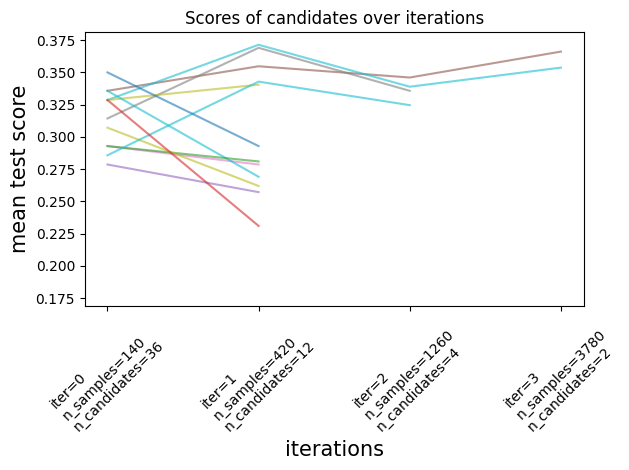

In [237]:
def plot_grid_result(grid_result):
    results = pd.DataFrame(grid_result.cv_results_)
    results["params_str"] = results.params.apply(str)
    results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
    mean_scores = results.pivot(
        index="iter", columns="params_str", values="mean_test_score"
    )
    ax = mean_scores.plot(legend=False, alpha=0.6)

    labels = [
        f"iter={i}\nn_samples={grid_result.n_resources_[i]}\nn_candidates={grid_result.n_candidates_[i]}"
        for i in range(grid_result.n_iterations_)
    ]

    ax.set_xticks(range(grid_result.n_iterations_))
    ax.set_xticklabels(labels, rotation=45, multialignment="left")
    ax.set_title("Scores of candidates over iterations")
    ax.set_ylabel("mean test score", fontsize=15)
    ax.set_xlabel("iterations", fontsize=15)
    plt.tight_layout()
    plt.show()

plot_grid_result(grid_result)

## Обучение модели

In [242]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from keras.models import load_model

def train_model(X_train, y_train, X_val, y_val, class_weights):
    if (cfg.use_saved_models):
        return load_model(cfg.checkpoint_path), None

    checkpoint = ModelCheckpoint(cfg.checkpoint_path, monitor='val_loss', save_best_only=True, mode='min', verbose=1)
    # Настраиваем callback для ранней остановки модели
    early_stopping = EarlyStopping(monitor="val_loss", min_delta=cfg.early_stopping_min_delta, patience=cfg.early_stopping_patience, verbose=1)
    # Настраиваем callback для TensorBoardd
    tensorboard = TensorBoard(log_dir="./logs")

    # X_train = separate_categorical_attributes(X_train)
    # X_val = separate_categorical_attributes(X_val)
    # Обучение модели
    full_history = m.fit(
        X_train.values.astype(float), y_train,
        epochs=cfg.num_epochs,
        batch_size=cfg.batch_size,
        validation_data=(X_val.values.astype(float), y_val),
        class_weight=class_weights,
        verbose=1,
        shuffle=False,
        callbacks=[
            checkpoint,
            early_stopping,
            tensorboard,
        ],
    )
    best_model = load_model(cfg.checkpoint_path)

    return best_model, full_history

In [252]:
from keras.optimizers import Adagrad

m = build_model(
    original_input_shape=X.shape[1],
    n_unique_actors=pd.concat([X['actor_1'], X['actor_2'], X['actor_3']]).nunique(),
    n_unique_directors=X['director'].nunique(),
    n_unique_production_companies=X['production_company'].nunique(),
    n_unique_production_countries=X['production_country'].nunique(),
    n_unique_domestic_distributor=X['domestic_distributor'].nunique(),
    n_classes=cfg.num_classes,
)
optimizer = Adagrad(
    learning_rate=0.01
)
m.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

best_model, full_history = train_model(X_train, y_train, X_val, y_val, class_weights)

Epoch 1/100
236/237 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2120 - loss: 1.3980
Epoch 1: val_loss improved from inf to 1.37906, saving model to 1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.2121 - loss: 1.3980 - val_accuracy: 0.3412 - val_loss: 1.3791
Epoch 2/100
232/237 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2325 - loss: 1.3869
Epoch 2: val_loss improved from 1.37906 to 1.37877, saving model to 1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2330 - loss: 1.3870 - val_accuracy: 0.3412 - val_loss: 1.3788
Epoch 3/100
237/237 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2606 - loss: 1.3858
Epoch 3: val_loss improved from 1.37877 to 1.37804, saving model to 1-best-tabular-model.keras
237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.2606 - loss: 1.3858 - val_accuracy: 0.3602 - val_loss: 1.3780
Epoch 4/100
235/237 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.2874 - loss: 1.3812
Epoch 4: val_loss im

## Исследование модели

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Exact match accuracy: 0.3791469194312796
One class away accuracy: 0.6966824644549763
Precision per class: [0.44230769 0.15625    0.34545455 0.5       ]
Recall per class: [0.62162162 0.12195122 0.37254902 0.22222222]
F1 score per class [0.51685393 0.1369863  0.35849057 0.30769231]
Macro Precision: 0.36100305944055944
Macro Recall: 0.33458602074097055
Macro F1: 0.33000577692104405
Micro Precision: 0.3791469194312796
Micro Recall: 0.3791469194312796
Micro F1: 0.3791469194312796


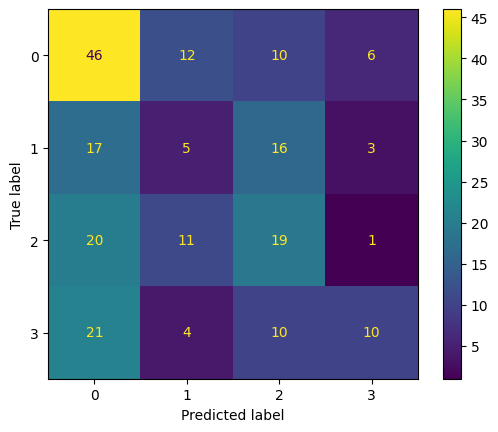

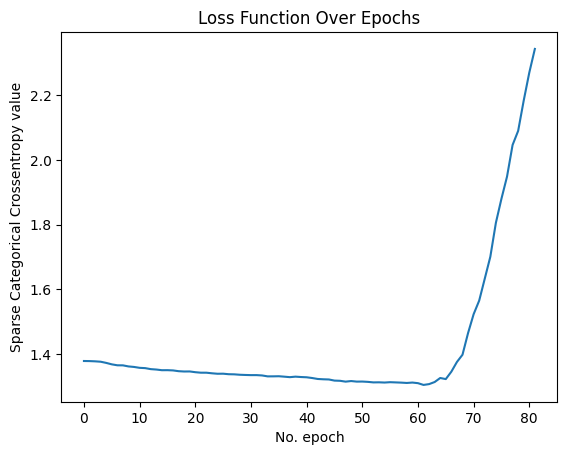

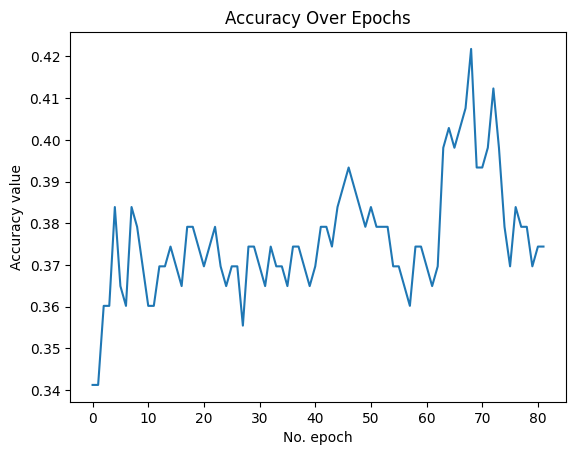

In [253]:
best_model = load_model(cfg.checkpoint_path)
# Проверка лучшей модели
inspect_model(best_model, X_test, y_test, 'tabular', history=full_history)

In [670]:
# %load_ext tensorboard
# %tensorboard --logdir ./logs

## Permutation Feature Importance

Метод перестановочной важности признаков (permutation feature importance) представляет собой способ расчёта степени влияния каждого признака на прогнозы модели.
Достоинством метода является то, что он применим
* для любой модели (white-box, black-box models);
* для любой задачи (классификация, регрессия и др.);
* для любой функции потерь.

Таким образом, перестановочная важность признака показывает, во сколько/на сколько среднее качество прогнозов изменится, если модель не сможет использовать информацию, хранящуюся в этом признаке, при построении прогнозов.

[Источник](https://deepmachinelearning.ru/docs/Machine-learning/Complex-models-interpretation/Permutation-feature-importance)

In [671]:
def permutation_feature_importance(model, X_test, y_test, num_iter=10):
    baseline = model.evaluate(separate_categorical_attributes(X_test), y_test)[1]

    onehot_columns = ['genre', 'release_month', 'mpaa']

    importance = {}

    for series_name, series in X_test.items():
        if (any(series_name.startswith(c) for c in onehot_columns)):
            continue
        importance[series_name] = []
        for _ in range(num_iter):
            X_permuted = X_test.copy()
            X_permuted[series_name] = np.random.permutation(series)
            score = model.evaluate(separate_categorical_attributes(X_permuted), y_test)[1]
            importance[series_name].append(score / baseline)
            
    for c in onehot_columns:
        columns_to_shuffle = []
        for series_name, series in X_test.items():
            if (series_name.startswith(c)):
                columns_to_shuffle.append(series_name)

        importance[c] = []

        for _ in range(num_iter):
            X_permuted = X_test.copy()
            X_permuted[columns_to_shuffle] = np.random.permutation(X_permuted[columns_to_shuffle])
            score = model.evaluate(separate_categorical_attributes(X_permuted), y_test)[1]
            importance[c].append(score / baseline)
        
    for k, v in importance.items():
        importance[k] = np.array(v)

    return importance

In [672]:
importance = permutation_feature_importance(best_model, X_test, y_test, num_iter=50)

7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4285 - loss: 1.2480  
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4329 - loss: 1.2578 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4126 - loss: 1.2750 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4102 - loss: 1.2753 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4150 - loss: 1.2794 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - accuracy: 0.4184 - loss: 1.2686 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3906 - loss: 1.2955 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3751 - loss: 1.2693 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4381 - loss: 1.2594 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4486 - loss: 1.2706 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4048 - loss: 1.2775 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4058 - loss: 1.2769 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.4287 - loss: 1.2677 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3913 - loss:

KeyboardInterrupt: 

Построение графика для "важности" признака.

Видно, что наиболее важными признаками являются бюджет, актеры, продюсерская компания и режиссер. Самыми не важными - язык оригинала и дистрибьютор.
На основе этого приянто решение по исключению этих признаков из датасета.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_importance(importance):
    data = {
        k: [np.percentile(v, 5), np.mean(v), np.percentile(v, 95)] for k, v in importance.items()
    }

    # Создание списка названий признаков и списков с минимальными и максимальными значениями важности
    features = list(data.keys())
    features.sort(key=lambda k: data[k][1], reverse=True)
    min_values = [data[feature][0] for feature in features]
    mean_values = [data[feature][1] for feature in features]
    max_values = [data[feature][2] for feature in features]

    # Создание графика
    fig, ax = plt.subplots()

    # Построение полосок для каждого признака
    for i, feature in enumerate(features):
        ax.plot([min_values[i], max_values[i]], [i, i], color='black', linewidth=3)
        ax.plot(mean_values[i], i, 'ko')

    # Настройка осей и заголовков
    ax.set_ylim(-1, len(features))  # Установка границ по оси Y
    ax.set_yticks(range(len(features)))  # Установка меток на оси Y
    ax.set_yticklabels(features)  # Назначение названий признаков на оси Y
    ax.set_xlabel("Важность признака")  # Заголовок оси X

    # Отображение графика
    plt.show()

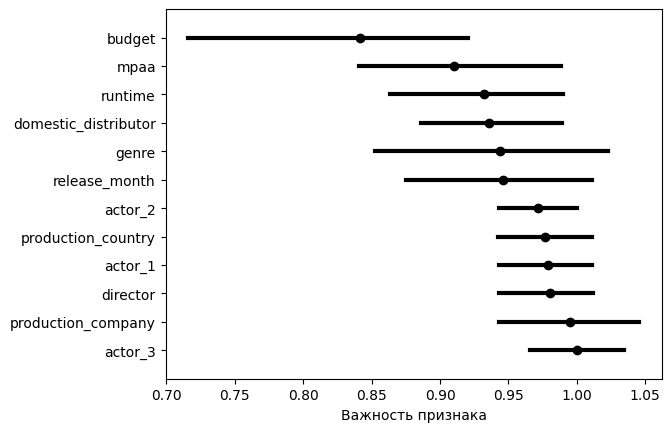

In [ ]:
plot_importance(importance)